In [86]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


# Notes

- not sure if the synthetitc dataset is useful for visualizing pca for feature selection, maybe we should reduce the features to 20 (10 signal 10 noise)
- TODO: Continue PCA feature extraction
- TODO: Does it make sense to do PCA after the first part? We can also do it at the end, or we leave it and add more in-depth analysis of Principle components (let's see what they are made out of -> but then probably a dataset with more interpretability would work better)
- Add something to Lasso and Ridge Cross Validation functions from SKLearn -> better explanations
- I think we probably can add Stepwise regression and hierarhcical clustering of feature correlations no? This notebook is not too loaded
- Maybe different dataset for PCR, could be smart
- Maybe plots chli apasse für pcr (cross validation plots)

TODO adjustments:
- Maybre remove the first part and directly go to overfitting to noise
- The train/test error plot for overfitting does not look as nice with the example with only a few points and features, it may be better if we use the really high-dimensional for this because it visualizes it nicely (i think the reason is, that p is not that much greater than n)
- (do we need to source the picture? https://bookdown.org/staedler_n/highdimstats/multiple-linear-regression.html#overfitting)

<br><br>
# **Table of Contents**

- [Finding "Significant" Patterns in Noise](#finding-significant-patterns-in-noise)
- [Overfitting to Noise](#overfitting-to-noise)
- [Principal Component Analysis (PCA): Finding Structure in High Dimensions](#principal-component-analysis-pca-finding-structure-in-high-dimensions)
- [Regularization Methods](#regularization-methods)
  - [Ridge Regression: Penalizing Large Coefficients](#ridge-regression-penalizing-large-coefficients-again-we-should-use-a-different-dataset-but-let-that-be-a-problem-for-once-i-got-all-the-code-and-ideas)
  - [LASSO Regression: Zeroing Out Irrelevant Features](#lasso-regression-zeroing-out-irrelevant-features)
  - [Elastic Net: Combining Ridge and LASSO](#elastic-net-combining-ridge-and-lasso)
  - [Regularization Methods Overview](#regularization-methods-overview)

<br><br>
# **Hands-On: Feature Selection and Regularization**

## Learning Goals
By the end of this session, you will be able to:

- **Identify the multiple testing problem in high-dimensional data**
  - Recognize how random correlations appear statistically significant in datasets with more features than samples
  - Understand why traditional statistical approaches fail when p >> n

- **Detect and avoid overfitting to noise**
  - Demonstrate how models can find "patterns" in completely synthetic data with no true relationships
  - Apply proper validation techniques to distinguish real signals from false discoveries

- **Apply dimensionality reduction for high-dimensional analysis**
  - Use PCA to identify meaningful structure in datasets with many features
  - Interpret principal components and explained variance ratios in high-dimensional contexts

- **Implement regularization techniques for feature selection**
  - Apply Ridge regression to penalize large coefficients and improve generalization
  - Use LASSO regression for automatic feature selection by zeroing out irrelevant variables
  - Combine approaches with Elastic Net to balance Ridge and LASSO penalties

<br><br>
# **Finding "Significant" Patterns in Noise**

First we look at a completely random dataset with 50 samples, 1000 features and 1 target variable. So there are no "real" relationships present in the data, however the tools we explored up to now may detect relationships.

We'll perform the following experiment: **test every single feature** for correlation with our target variable. Remember, our data is completely random - there should be NO real relationships.

**What we're testing:**
- Calculate correlation coefficient between each of the 1000 features and the target
- Compute p-values to test if correlations are "statistically significant" (p < 0.05)
- See how many features appear "significant" purely by chance

**The Multiple Testing Problem:**
When we test many hypotheses simultaneously, we expect some to appear significant by pure chance:
- With α = 0.05, we expect 5% of tests to be "significant" even for random data
- 1000 features × 0.05 = **~50 expected "significant" correlations**
- This is the **false discovery** problem in high-dimensional data!

Let's see if this theoretical expectation matches reality...

In [ ]:
# Load our synthetic dataset
df = pd.read_csv('synthetic_highdim_random_dataset.csv')
X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset shape: {df.shape}")
print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}")
print(f"Ratio: {X.shape[1]/X.shape[0]:.1f} features per sample!")
print(f"\n⚠️  Remember: ALL data is completely random - no true relationships exist!")

Dataset shape: (50, 1001)
Samples: 50, Features: 1000
Ratio: 20.0 features per sample!

⚠️  Remember: ALL data is completely random - no true relationships exist!


🎲 RANDOM DATA ANALYSIS:
Features with p < 0.05: 45 out of 1000
Expected by chance: ~50
Strongest 'significant' correlation: 0.4680


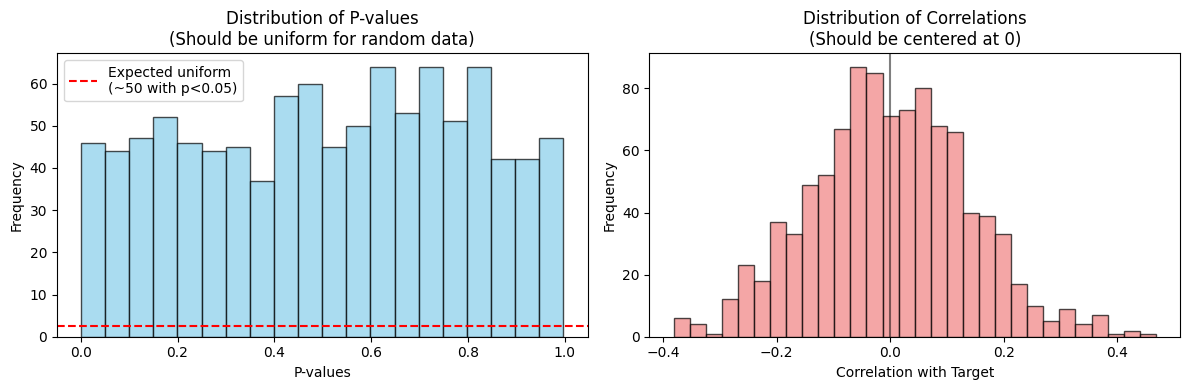

In [4]:
# Calculate correlations between ALL features and target
correlations = []
p_values = []

for feature in X.columns:
    corr, p_val = stats.pearsonr(X[feature], y)
    correlations.append(corr)
    p_values.append(p_val)

corr_df = pd.DataFrame({
    'feature': X.columns,
    'correlation': correlations,
    'p_value': p_values,
    'abs_correlation': np.abs(correlations)
}).sort_values('abs_correlation', ascending=False)

# Find "significant" correlations
significant = corr_df[corr_df['p_value'] < 0.05]

print(f"🎲 RANDOM DATA ANALYSIS:")
print(f"Features with p < 0.05: {len(significant)} out of {len(corr_df)}")
print(f"Expected by chance: ~{len(corr_df) * 0.05:.0f}")
print(f"Strongest 'significant' correlation: {significant.iloc[0]['correlation']:.4f}")

# Visualize the distribution of p-values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(p_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axhline(y=len(p_values)*0.05/20, color='red', linestyle='--', 
            label=f'Expected uniform\n(~{len(p_values)*0.05:.0f} with p<0.05)')
plt.xlabel('P-values')
plt.ylabel('Frequency')
plt.title('Distribution of P-values\n(Should be uniform for random data)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(correlations, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Correlation with Target')
plt.ylabel('Frequency')
plt.title('Distribution of Correlations\n(Should be centered at 0)')

plt.tight_layout()
plt.show()

### Results:
- **45 features with p < 0.05** out of 1000 total features
- **Strongest "significant" correlation: 0.47** - quite convincing looking!

### Left Plot - P-value Distribution:
- **Uniform distribution**: P-values are spread evenly from 0 to 1 (as expected for random data)
- **Red dashed line**: Shows expected frequency for each bin under uniform distribution
- **The trap**: Even random data produces some low p-values that appear "significant"!

### Right Plot - Correlation Distribution:
- **Normal distribution centered at 0**: Exactly what we expect for random correlations
- **No real relationships**: The bell curve confirms no systematic patterns exist
- **Random scatter**: Some correlations appear strong (like our 0.47!) but are pure noise

### Key Insights:
1. **Theory matches reality**: We got 45 vs expected ~50 - statistical theory works!
2. **0.47 correlation looks impressive** but it's completely meaningless random noise
3. **Without multiple testing correction**, we'd wrongly conclude these 45 features are important
4. **This is why high-dimensional data is dangerous** - noise can easily masquerade as signal

**The Bottom Line:** In high dimensions with small samples, **random chance can create convincing but false patterns**. Let's see what we can do against this now!

---
<br><br>
# **Overfitting to Noise**

We will demonstrate how Models can overfit to noise if we have a lot of features and not enough samples for the model to learn the actual relevant relationships. For this we use a new generated dataset that has 1 relevant feature that has a relationship with the target value and 14 features that are just random noise. 

Dataset Generated:
- Samples: 12
- Features: 15
- True relationship: Y = 2 * X1 + noise(0, 0.5)
- Only X1 is relevant, X2-X15 are pure noise


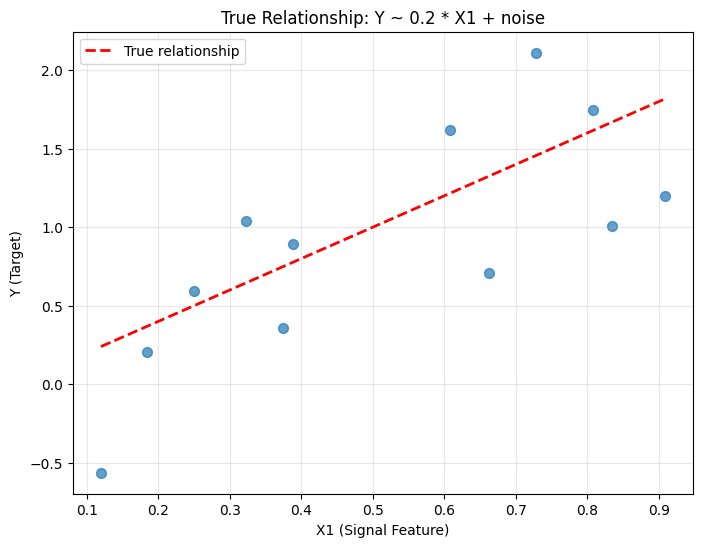


Data summary:
X shape: (12, 15)
y shape: (12,)
X1 range: [0.12, 0.91]
Y range: [-0.56, 2.11]


In [ ]:
# Create dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Generate dataset
n_samples = 12
n_total_features = 15

# Generate features: all features are random noise
X = np.random.uniform(size=(n_samples, n_total_features))

# Create target: only depends on first feature
# Y ~ X1 * 2 + noise(0, 0.5)
true_coefficient = 2
y = true_coefficient * X[:, 0] + np.random.normal(0, 0.5, n_samples)

# Quick visualization of the true relationship
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], y, alpha=0.7, s=50)
plt.xlabel('X1 (Signal Feature)')
plt.ylabel('Y (Target)')
plt.title('True Relationship: Y ~ 2 * X1 + noise')
plt.grid(True, alpha=0.3)

# Add true relationship line
x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
true_y = true_coefficient * x1_range
plt.plot(x1_range, true_y, 'r--', linewidth=2, label='True relationship')
plt.legend()
plt.show()

print(f"\nData summary:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X1 range: [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}]")
print(f"Y range: [{y.min():.2f}, {y.max():.2f}]")

Now let's fit a simple linear regression using only X1 (the true signal feature):

**Model: Y ~ X1**

- Uses the correct feature that actually generates Y
- Should recover the true coefficient (≈ 2)
- Serves as our baseline for comparison

Linear Regression with X1 only:
True coefficient: 2
Fitted coefficient: 1.980
Fitted intercept: -0.112


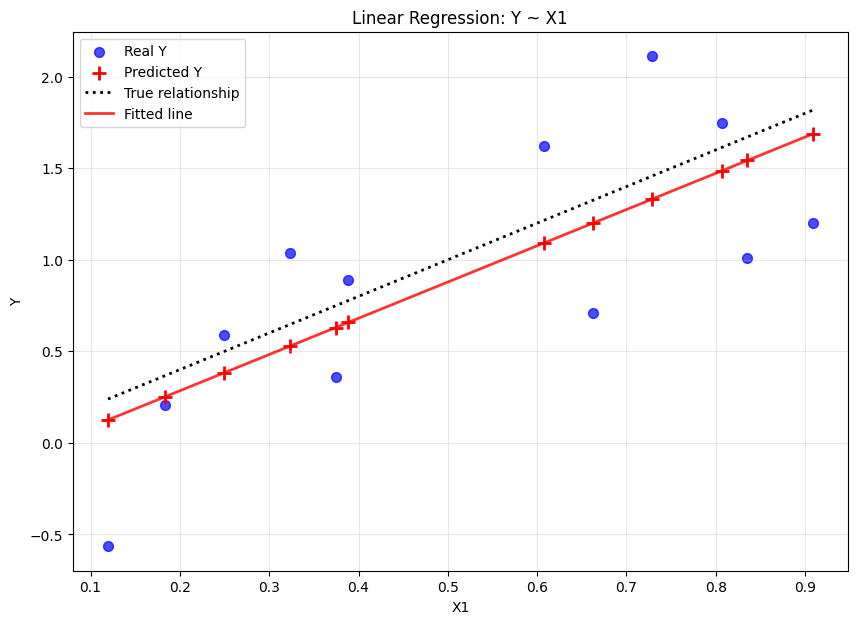


Performance Metrics:
MSE: 0.2190


In [ ]:
# Fit linear regression using only X1
X1 = X[:, 0].reshape(-1, 1)  # Only first feature

# Fit the model: y ~ X1
model_X1 = LinearRegression()
model_X1.fit(X1, y)

# Get predictions
y_pred = model_X1.predict(X1)

# Create scatter plot
plt.figure(figsize=(10, 7))

# Plot real Y values as points
plt.scatter(X[:, 0], y, alpha=0.7, s=50, color='blue', label='Real Y')

# Plot predicted Y values as crosses
plt.scatter(X[:, 0], y_pred, marker='+', s=100, color='red', linewidth=2, label='Predicted Y')

# Plot true relationship as dotted line
x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
true_y = true_coefficient * x1_range
plt.plot(x1_range, true_y, 'k:', linewidth=2, label='True relationship')

# Plot fitted line
fitted_y = model_X1.predict(x1_range.reshape(-1, 1))
plt.plot(x1_range, fitted_y, 'r-', linewidth=2, alpha=0.8, label='Fitted line')

plt.xlabel('X1')
plt.ylabel('Y')
plt.title('Linear Regression: Y ~ X1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print performance metrics
mse = mean_squared_error(y, y_pred)

print(f"\nPerformance Metrics:")
print(f"MSE: {mse:.4f}")

As we can see, the linear regression nicely recovers the true relationship. Now let's explore what happens when we include additional noise features.

**Models to compare:**
- **p=4**: Include 3 irrelevant features alongside X1
- **p=8**: Include 7 irrelevant features alongside X1  
- **p=15**: Include 14 irrelevant features alongside X1

Each model will fit: Y ~ X1 + X2 + ... + Xp

We'll plot the same X1 vs Y relationship to see how adding noise features affects predictions.

p=4 features - MSE: 0.1921
p=8 features - MSE: 0.1592
p=15 features - MSE: 0.0000


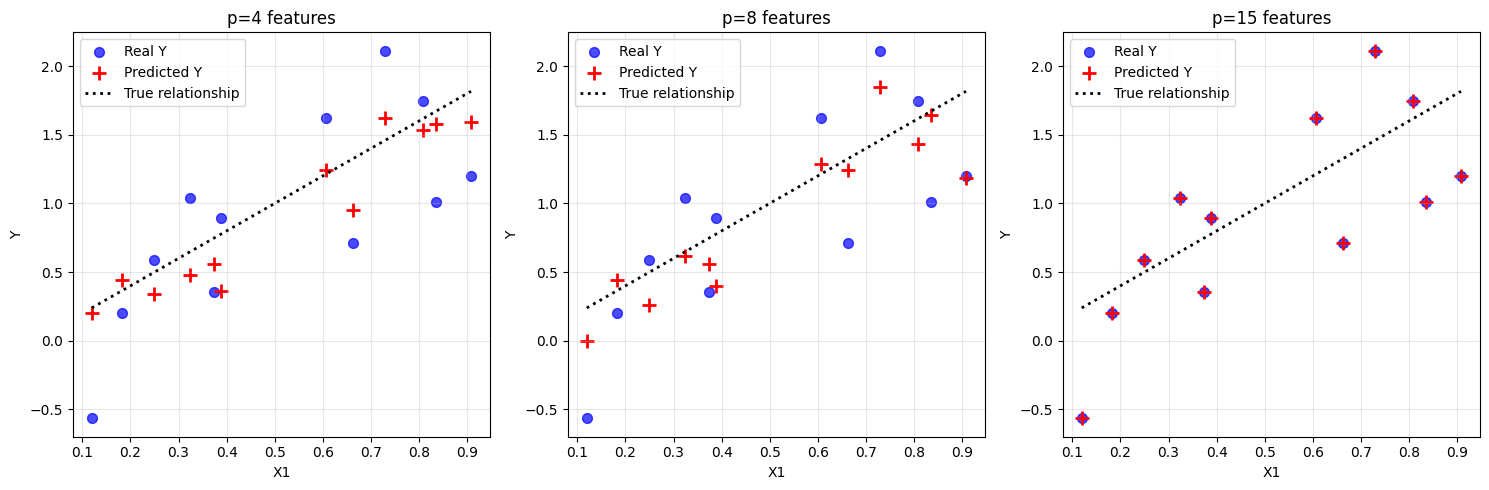


Observation: As we add more noise features (p=4→8→15),
the predicted Y values (red crosses) deviate more from the true Y values (blue dots)
even though we're only plotting against X1!


In [ ]:
# Test different numbers of features
feature_counts = [4, 8, 15]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, p in enumerate(feature_counts):
    ax = axes[i]
    
    # Use first p features
    X_p = X[:, :p]
    
    # Fit model with p features
    model_p = LinearRegression()
    model_p.fit(X_p, y)
    
    # Get predictions
    y_pred_p = model_p.predict(X_p)
    
    # Plot real Y values as points
    ax.scatter(X[:, 0], y, alpha=0.7, s=50, color='blue', label='Real Y')
    
    # Plot predicted Y values as crosses
    ax.scatter(X[:, 0], y_pred_p, marker='+', s=100, color='red', linewidth=2, label='Predicted Y')
    
    # Plot true relationship as dotted line
    x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    true_y = true_coefficient * x1_range
    ax.plot(x1_range, true_y, 'k:', linewidth=2, label='True relationship')
    
    # Formatting
    ax.set_xlabel('X1')
    ax.set_ylabel('Y')
    ax.set_title(f'p={p} features')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calculate and print performance metrics
    mse_p = mean_squared_error(y, y_pred_p)
    print(f"p={p} features - MSE: {mse_p:.4f}")

plt.tight_layout()
plt.show()

With increasing number of features, the fitted values start to deviate from the true model (dotted line) and move closer towards the observed data points. With p=15, the fitted values match the data perfectly—the model captures noise and overfits.

**Key observations:**
- **p=4**: Slight deviation from true relationship
- **p=8**: More pronounced overfitting to individual points  
- **p=15**: Perfect fit to training data (including noise)

Let's examine what happens to the estimated coefficients as we add more features. Since only X1 should have a non-zero coefficient (≈2), this reveals how noise features corrupt parameter estimates.

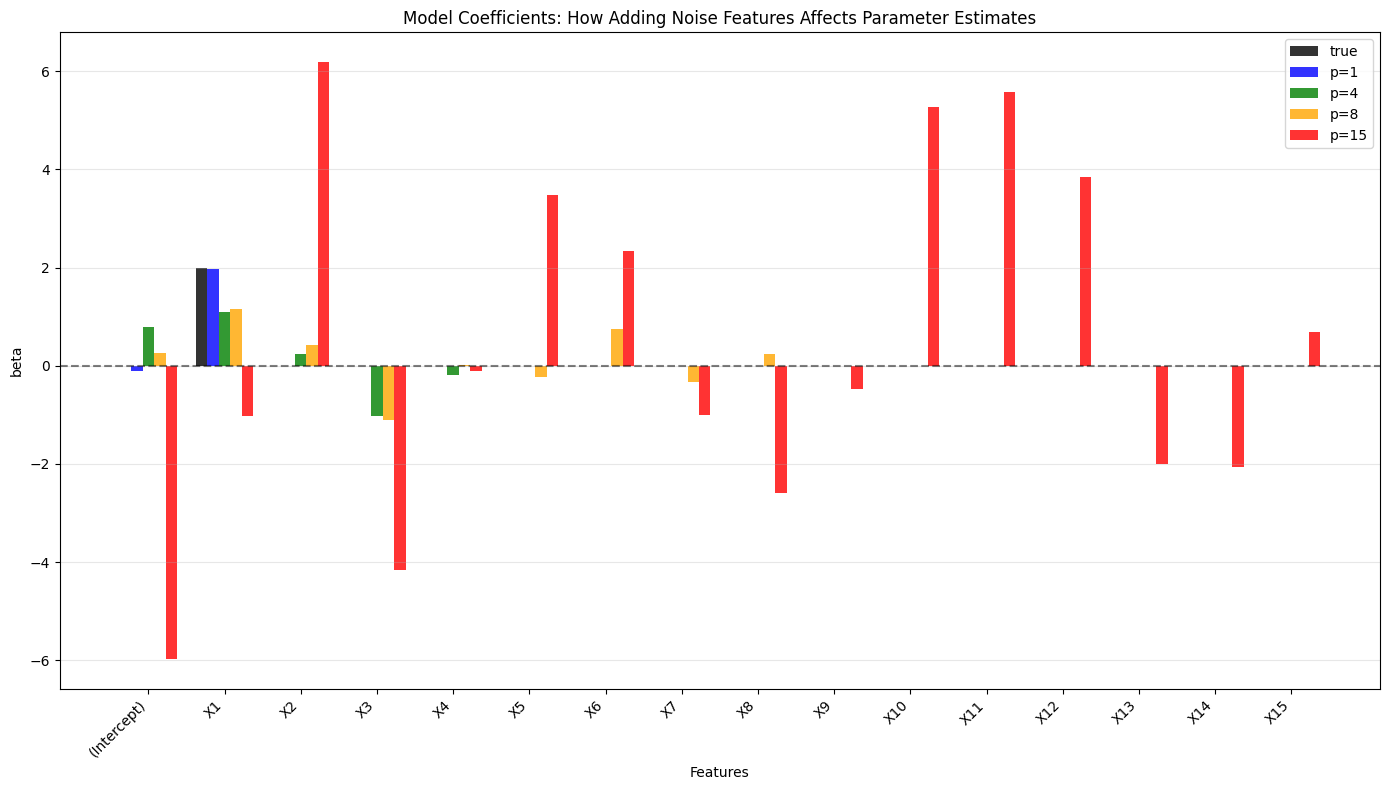

In [ ]:
# Fit models with different numbers of features and extract coefficients
feature_counts = [1, 4, 8, 15]
all_coefficients = {}

# True coefficients (only X1 should be 2, all others should be 0)
true_coeffs = np.zeros(15)
true_coeffs[0] = 2

for p in feature_counts:
    # Use first p features
    X_p = X[:, :p]
    
    # Fit model
    model_p = LinearRegression()
    model_p.fit(X_p, y)
    
    # Store coefficients (pad with zeros for missing features)
    coeffs = np.zeros(15)
    coeffs[:p] = model_p.coef_
    all_coefficients[f'p={p}'] = coeffs
    
# Create coefficient plot
plt.figure(figsize=(14, 8))

# Define colors for each model
colors = ['black', 'blue', 'green', 'orange', 'red']
model_names = ['true', 'p=1', 'p=4', 'p=8', 'p=15']

# Position parameters for grouped bars
x_positions = np.arange(16)  # 15 features + intercept
bar_width = 0.15
x_offset = np.arange(len(model_names)) * bar_width

# Plot true coefficients (intercept = 0, X1 = 0.2, rest = 0)
true_all = np.zeros(16)
true_all[1] = 2  # X1 coefficient
plt.bar(x_positions + x_offset[0], true_all, bar_width, 
        color=colors[0], label='true', alpha=0.8)

# Plot model coefficients
for i, p in enumerate(feature_counts):
    model_coeffs = np.zeros(16)
    model_coeffs[0] = LinearRegression().fit(X[:, :p], y).intercept_  # Intercept
    model_coeffs[1:p+1] = LinearRegression().fit(X[:, :p], y).coef_  # Coefficients
    
    plt.bar(x_positions + x_offset[i+1], model_coeffs, bar_width,
            color=colors[i+1], label=f'p={p}', alpha=0.8)

# Formatting
plt.xlabel('Features')
plt.ylabel('beta')
plt.title('Model Coefficients: How Adding Noise Features Affects Parameter Estimates')
plt.xticks(x_positions + bar_width * 2, 
          ['(Intercept)'] + [f'X{i}' for i in range(1, 16)], 
          rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

The coefficient plot reveals the devastating effects of overfitting:

**Key findings:**
- **True model**: Only X1=2, all others=0
- **p=1 (blue)**: Correctly recovers X1≈2  
- **p=4,8,15 (green/orange/red)**: X1 estimate becomes increasingly wrong
- **Noise features**: Get large non-zero coefficients (should be 0)

With p=15 features on our small dataset, we're heavily overfitting and not modeling the real relationship!

This overfitting becomes even more apparent when we test our models on new unseen data. Let's examine how badly overfitted models perform using MSE and R² scores.

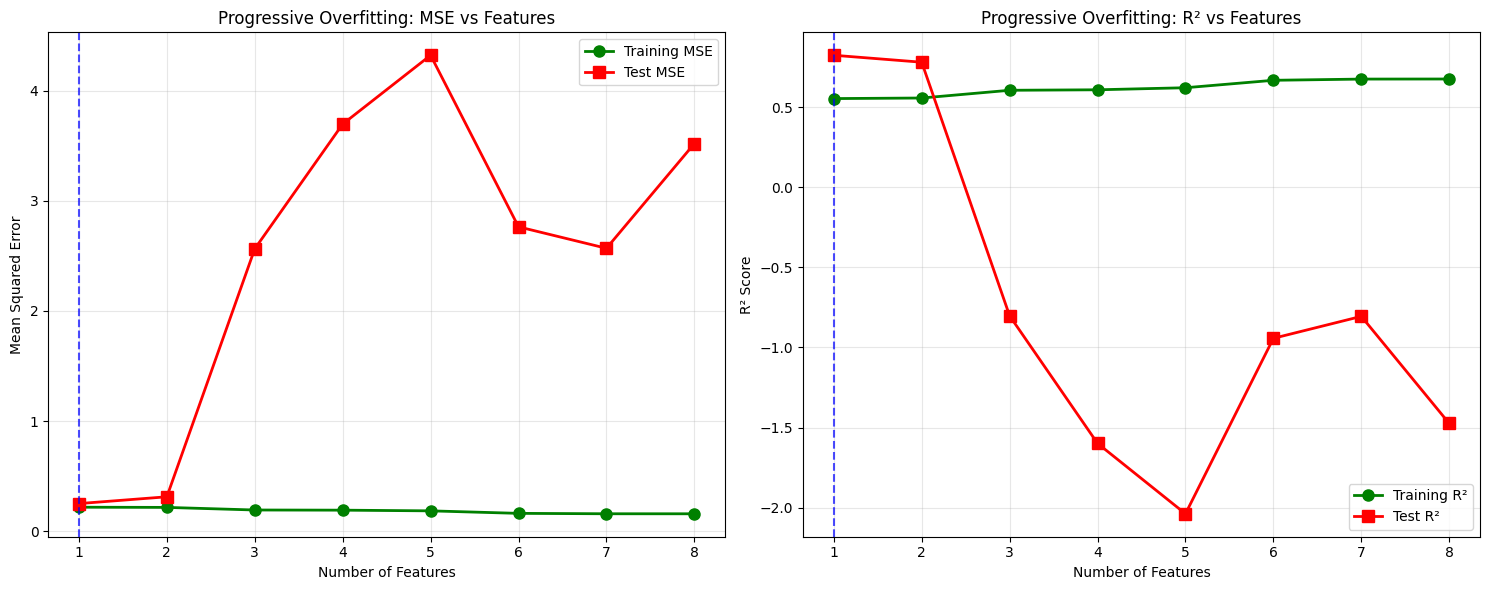

In [69]:
# Generate a separate test set (12 new points)
np.random.seed(123)  # Different seed for test set
n_test = 12

# Generate test features and target
X_test = np.random.randn(n_test, n_total_features)
y_test = true_coefficient * X_test[:, 0] + np.random.normal(0, 0.5, n_test)

# Calculate train and test performance for all feature counts (1 to 15)
feature_range = range(1, 9)
train_mse_list = []
test_mse_list = []
train_r2_list = []
test_r2_list = []

for p in feature_range:
    # Use first p features
    X_train_p = X[:, :p]
    X_test_p = X_test[:, :p]
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train_p, y)
    
    # Predictions
    y_train_pred = model.predict(X_train_p)
    y_test_pred = model.predict(X_test_p)
    
    # Calculate MSE
    train_mse = mean_squared_error(y, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Calculate R²
    train_r2 = model.score(X_train_p, y)
    test_r2 = model.score(X_test_p, y_test)
    
    # Store results
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

# Create the plots with better scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# MSE plot - use linear scale for both axes
ax1.plot(feature_range, train_mse_list, 'o-', color='green', linewidth=2, markersize=8, label='Training MSE')
ax1.plot(feature_range, test_mse_list, 's-', color='red', linewidth=2, markersize=8, label='Test MSE')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Progressive Overfitting: MSE vs Features')
#ax1.set_yscale('log')  # Use log scale for better visibility
ax1.axvline(x=1, color='blue', linestyle='--', alpha=0.7)  # Mark the true number of relevant features
ax1.grid(True, alpha=0.3)
ax1.legend()
#ax1.set_xlim(0.5, 15.5)  # Better x-axis limits
#ax1.set_ylim(0.01, 200) # Better y-axis limits

# R² plot - use linear scale for both axes
ax2.plot(feature_range, train_r2_list, 'o-', color='green', linewidth=2, markersize=8, label='Training R²')
ax2.plot(feature_range, test_r2_list, 's-', color='red', linewidth=2, markersize=8, label='Test R²')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('R² Score')
ax2.set_title('Progressive Overfitting: R² vs Features')
ax2.axvline(x=1, color='blue', linestyle='--', alpha=0.7)  # Mark the true number of relevant features
ax2.grid(True, alpha=0.3)
ax2.legend()
#ax2.set_xlim(0.5, 15.5)  # Better x-axis limits
#ax2.set_ylim(-0.1, 1.1)  # Better y-axis limits

plt.tight_layout()
plt.show()


This demonstrates why **"more features = better"** is a dangerous assumption in machine learning!

- **Training performance** (green): Stays good/improves with more features
- **Test performance** (red): Degrades rapidly after p=1 
- **Sweet spot**: p=1 (marked by blue line) - the true number of relevant features
- **Beyond p=1**: Each additional noise feature hurts generalization

*Note: We only show up to 8 features for readability - test error explodes even further with p=9-15.*

Our test MSE and R² scores directly measure the **generalization error**!

**What is Generalization Error?**
- Measures how well a model performs on **new, unseen data**
- The ultimate goal: good predictions for the future, not just fitting existing data

## Model Selection and Cross-Validation

**The Model Selection Challenge:**
- Machine learning explores multiple models (m = 1, 2, ..., M) to find the best one
- Goal: Select the model with lowest generalization error
- **Problem**: Can't use test data for model selection - it must stay "untouched" for final evaluation, also sometimes we don't have a lot of data available
- **Solution**: Approximate generalization error using training data only

**Cross-Validation Approach:**
- Split training data into **folds** (e.g., 5 or 10 parts)
- For each model candidate:
  - Train on k-1 folds
  - Validate on the remaining fold
  - Repeat for all fold combinations
- Average validation errors across folds = **CV score**
- Select model with best CV score
- **Finally**: Evaluate chosen model on test set

<img src="crossvalidation.jpg" alt="Cross-validation illustration" width="600"/>

(do we need to source the picture? https://bookdown.org/staedler_n/highdimstats/multiple-linear-regression.html#overfitting)

Let's provide a quick example with a newly simulated dataset. This time we again have 15 features but our target variable is dependend on the first 4. We then fit linear models on the data using 1 to 15 features and calculated the *CV scores*.

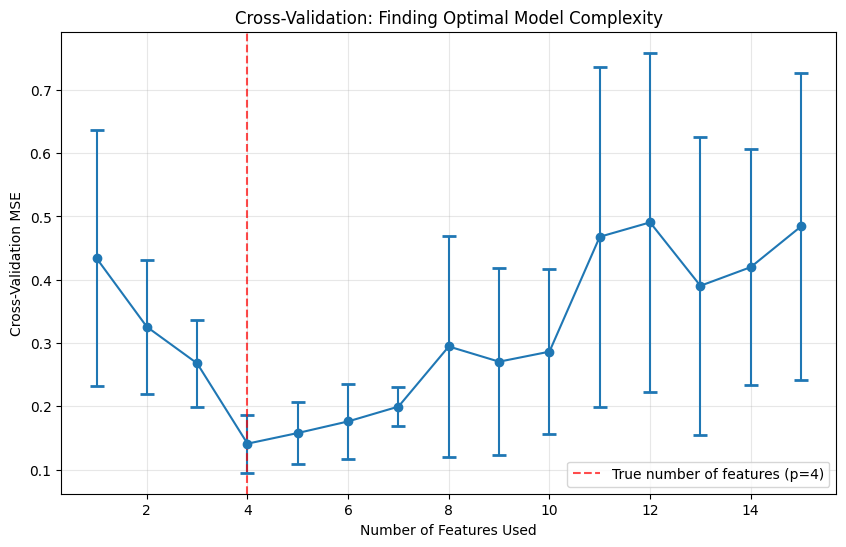

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Generate dataset
n_samples = 25
n_features = 15

# Create feature matrix
X = np.random.randn(n_samples, n_features)

# Create target variable with 4 true features
true_coefficients = [0.3, 0.5, 0.2, 0.4]  # Only first 4 features matter
y = (X[:, 0] * true_coefficients[0] + 
     X[:, 1] * true_coefficients[1] + 
     X[:, 2] * true_coefficients[2] + 
     X[:, 3] * true_coefficients[3] + 
     np.random.normal(0, 0.3, n_samples))  # Add noise

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation for different numbers of features
cv_scores = []
cv_stds = []
feature_counts = range(1, n_features + 1)

for p in feature_counts:
    # Use first p features
    X_subset = X_scaled[:, :p]
    
    # 5-fold cross-validation
    scores = cross_val_score(LinearRegression(), X_subset, y, 
                           cv=5, scoring='neg_mean_squared_error')
    
    # Convert to positive MSE and store
    cv_scores.append(-scores.mean())
    cv_stds.append(scores.std())

# Plot results
plt.figure(figsize=(10, 6))
plt.errorbar(feature_counts, cv_scores, yerr=cv_stds, 
             marker='o', capsize=5, capthick=2)
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, 
            label='True number of features (p=4)')
plt.xlabel('Number of Features Used')
plt.ylabel('Cross-Validation MSE')
plt.title('Cross-Validation: Finding Optimal Model Complexity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

- **Underfitting (p=1-3)**: High CV error - model too simple to capture true relationship
- **Sweet spot (p=4-6)**: Lowest CV error around p=4-5 - matches true complexity!
- **Overfitting (p>6)**: Rising CV error - model fits noise, hurts generalization

**Key Insights:**
- **Error bars**: Show variability across CV folds - wider bars indicate less stable performance
- **Minimum at p=4**: Cross-validation correctly identifies the true number of relevant features
- **Validation**: CV successfully balances underfitting vs. overfitting

CV found the optimal complexity (p≈4) without ever seeing test data, matching our true model structure perfectly.

This demonstrates why cross-validation is the gold standard for model selection in practice.

---
<br><br>
# **Principal Component Analysis (PCA): Finding Structure in High Dimensions**

We've seen how adding irrelevant features hurts model performance. **Principal Component Analysis (PCA)** offers a smarter approach: instead of manually selecting features, we transform all features into a smaller set of **uncorrelated components** that capture the most important patterns in the data.

**The PCA Approach:**
- **Create new features**: Linear combinations of all original features
- **Rank by importance**: Components ordered by variance explained
- **Reduce dimensionality**: Keep only the top k components
- **Remove redundancy**: All components are uncorrelated
- **Combat overfitting**: Work in a lower-dimensional space

**Key insight**: We can often capture 90%+ of data variance with far fewer components than original features! Let's investigate the explained variance of PCA on a dataset with 22 features and 1 target variable.

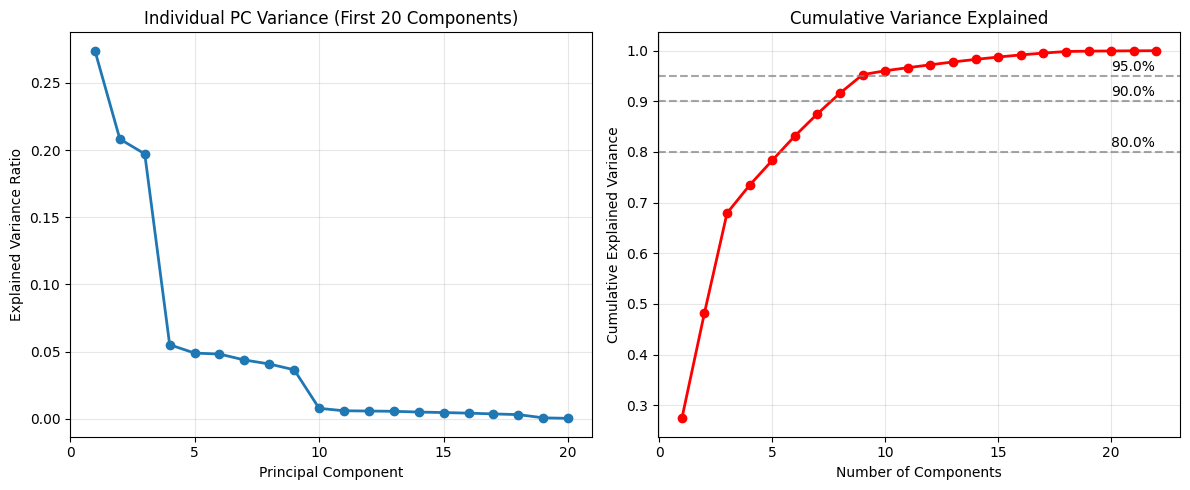

In [96]:
df = pd.read_csv('structured_dataset_for_pca.csv')

# Load data and separate features/target
X = df.drop('target', axis=1)
y = df['target']

# Step 1: Standardize the features (essential for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Fit PCA on all components first to analyze variance
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for different variance thresholds
thresholds = [0.8, 0.9, 0.95, 0.99]
components_needed = {}
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    components_needed[threshold] = n_components

# Visualize explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 21), pca_full.explained_variance_ratio_[:20], 'o-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual PC Variance (First 20 Components)')
plt.xticks(range(0, 21, 5))  # Set x-ticks at 0, 5, 10, 15, 20
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, 23), cumulative_variance[:50], 'o-', linewidth=2, color='red')
for threshold in [0.8, 0.9, 0.95]:
    plt.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7)
    plt.text(20, threshold+0.01, f'{threshold*100}%', fontsize=10)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.xticks(range(0, 21, 5))  # Set x-ticks at 0, 5, 10, 15, 20
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Principal Component Regression (PCR)

We can use the principle components as our predictor variables for the target value, this is called **Principle Component Regression (PCR)**.

**How PCR Works:**
1. **Transform**: Apply PCA to create principal components from all features
2. **Select**: Choose the first k components (those explaining most variance)
3. **Regress**: Fit linear regression using only these k components
4. **Predict**: Transform new data and make predictions

**The Trade-off:**
- **Few components**: Fast, less overfitting, but may miss important patterns
- **Many components**: Captures more variance but risks overfitting
- **Sweet spot**: Use cross-validation to find optimal number of components

Let's test PCR performance across different numbers of components using cross-validation!

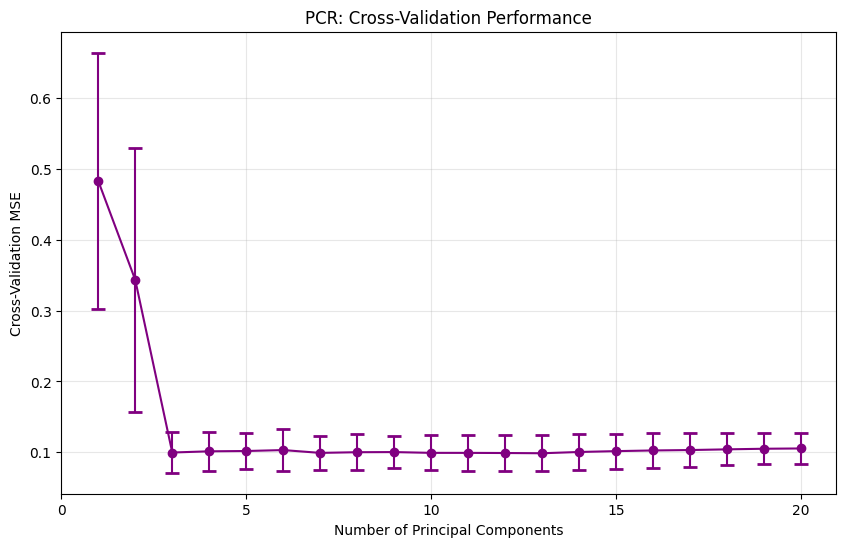

In [97]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# Cross-validation for PCR with different numbers of components
n_components_range = range(1, 21)  # Test 1 to 20 components
cv_scores_pcr = []
cv_stds_pcr = []

for n_comp in n_components_range:
    # Create pipeline: PCA + Linear Regression
    pcr_pipeline = Pipeline([
        ('pca', PCA(n_components=n_comp)),
        ('regression', LinearRegression())
    ])
    
    # 5-fold cross-validation
    scores = cross_val_score(pcr_pipeline, X_scaled, y, 
                           cv=5, scoring='neg_mean_squared_error')
    
    # Convert to positive MSE and store
    cv_scores_pcr.append(-scores.mean())
    cv_stds_pcr.append(scores.std())

# Plot PCR cross-validation results
plt.figure(figsize=(10, 6))
plt.errorbar(n_components_range, cv_scores_pcr, yerr=cv_stds_pcr, 
             marker='o', capsize=5, capthick=2, color='purple')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cross-Validation MSE')
plt.title('PCR: Cross-Validation Performance')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 21, 5))  # Set x-ticks at 0, 5, 10, 15, 20
plt.show()

# Find optimal number of components
optimal_n_comp = n_components_range[np.argmin(cv_scores_pcr)]
min_mse = min(cv_scores_pcr)
variance_at_optimal = cumulative_variance[optimal_n_comp-1]

**Plot Interpretation:**
- **Sweet spot at k=3**: CV error minimizes with just 3 principal components
- **Diminishing returns**: Beyond 3-5 components, performance plateaus or slightly worsens
- **Efficiency**: We achieve optimal performance using only 3 components vs. 22 original features

**Principal Component Regression Overview:**

**Benefits:**
- **Reduces overfitting**: Uses k components instead of all original features
- **Handles high-dimensional data**: Especially effective with many correlated features
- **Computational efficiency**: Faster training and prediction

**Caveats:**
- **Not feature selection**: Still uses all original features (as linear combinations)
- **Reduced interpretability**: Components lose connection to original feature meanings
- **Unsupervised transformation**: PCA ignores target variable - high-variance directions may not predict well
- **Potential information loss**: Important predictive patterns with low variance might be discarded

PCR works best when features are highly correlated and the first few components capture most predictive information.

---
<br><br>
# **Regularization Methods**

Another approach to improve the fit of the model to a high-dimensional dataset are **Regularization Methods**. Here we don't perform dimensionality reduction or any other tool to filter out features or information, but we *constrain* or *regularize* the **coefficients** of our features towards zero! We will take a look at the two best-known techniques **ridge** and **lasso regression**, as well as their combination **elastic net**.

## Ridge Regression: Penalizing Large Coefficients (Again we should use a different dataset, but let that be a problem for once i got all the code and ideas)

**The Core Idea:**
Ridge regression adds a **penalty term** to the standard linear regression loss function that discourages large coefficient values:

**Standard Linear Regression:**
Loss = MSE = Σ(y - ŷ)²

**Ridge Regression:**
Loss = MSE + α × Σ(β²)

**How Ridge Works:**
- **α (alpha)**: Regularization strength parameter
  - α = 0: No penalty for size of parameters β (standard linear regression)
  - α → ∞: All coefficients β shrink toward zero
- **L2 Penalty**: Penalizes the **sum of squared coefficients**
- **Effect**: Coefficients are **shrunk** but never exactly zero
- **Benefit**: Reduces overfitting by preventing any single feature from dominating

**When Ridge Helps:**
- Many features are somewhat relevant (multicollinearity)
- Want to keep all features but reduce their impact
- Prefer smooth, continuous shrinkage over feature elimination

Let's simulate a new dataset to showcase the effect of the α parameter. 

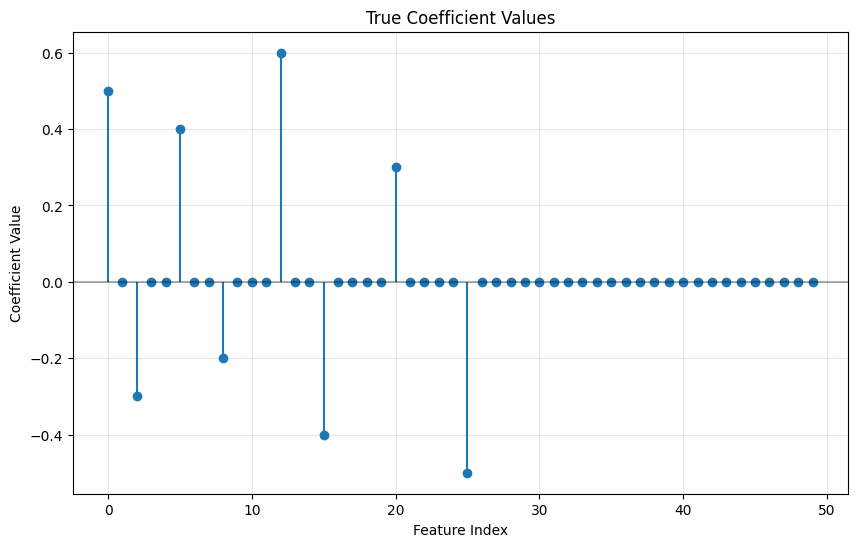

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Create a challenging dataset for shrinkage methods
n_samples = 80  # Small sample size
n_features = 50  # High dimensionality (p > n problem)

# Generate correlated features
# Create groups of correlated features to simulate multicollinearity
X = np.random.randn(n_samples, n_features)

# Add correlation structure
for i in range(0, n_features, 5):  # Every 5 features are correlated
    end_idx = min(i+5, n_features)
    group_size = end_idx - i
    # Make features within group correlated
    base_feature = X[:, i]
    for j in range(i+1, end_idx):
        X[:, j] = 0.7 * base_feature + 0.3 * X[:, j]  # 70% correlation

# Create target with sparse signal (only some features matter)
true_coefficients = np.zeros(n_features)
# Only first 8 features have non-zero coefficients
signal_features = [0, 2, 5, 8, 12, 15, 20, 25]
true_coefficients[signal_features] = [0.5, -0.3, 0.4, -0.2, 0.6, -0.4, 0.3, -0.5]

# Generate target with noise
y = X @ true_coefficients + np.random.normal(0, 0.2, n_samples)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)
# Show true coefficients
plt.figure(figsize=(10, 6))
plt.stem(range(n_features), true_coefficients, basefmt=' ')
plt.title('True Coefficient Values')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

**Dataset Setup:**
We've created a challenging high-dimensional dataset to demonstrate shrinkage methods:
- **50 features**
- **8 signal features** that actually predict the target (shown in the plot above) and **42 noise features** that don't contribute to prediction
- **80 samples**

This setup is perfect for testing regularization methods because ordinary least squares would severely overfit. Next, we'll use **cross-validation** to find the optimal regularization strength (α) that balances bias and variance.

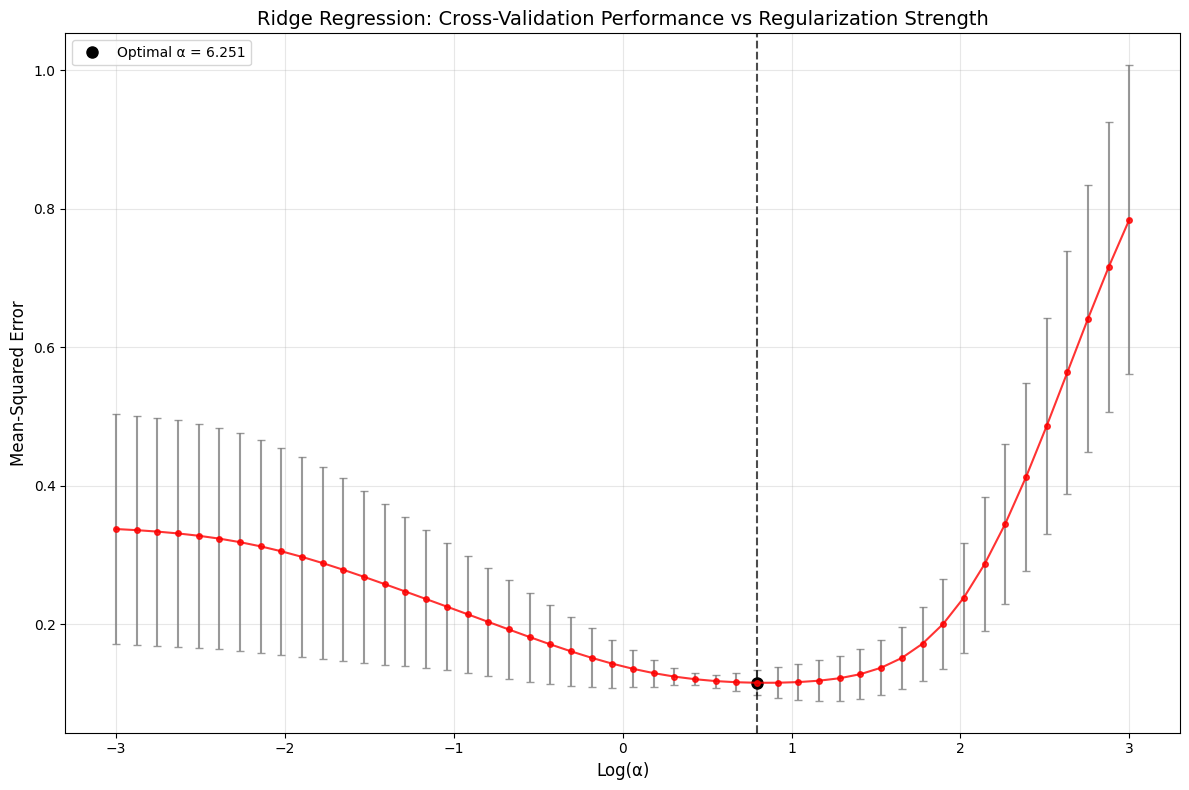

In [127]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define range of alpha values (regularization strength)
# Use log scale from very small to very large values
alphas = np.logspace(-3, 3, 50)  # From 0.001 to 1,000

# Store cross-validation scores
cv_scores = []
cv_stds = []

# Cross-validation for each alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train, y_train, 
                           cv=5, scoring='neg_mean_squared_error')
    
    # Convert to positive MSE
    cv_scores.append(-scores.mean())
    cv_stds.append(scores.std())

# Convert to numpy arrays for easier manipulation
cv_scores = np.array(cv_scores)
cv_stds = np.array(cv_stds)

# Plot results
plt.figure(figsize=(12, 8))
plt.errorbar(np.log10(alphas), cv_scores, yerr=cv_stds, 
             marker='o', markersize=4, capsize=3, capthick=1,
             color='red', ecolor='gray', alpha=0.8)

# Find optimal alpha
optimal_idx = np.argmin(cv_scores)
optimal_alpha = alphas[optimal_idx]
optimal_score = cv_scores[optimal_idx]

# Mark optimal point
plt.axvline(x=np.log10(optimal_alpha), color='black', linestyle='--', alpha=0.7)
plt.plot(np.log10(optimal_alpha), optimal_score, 'ko', markersize=8, 
         label=f'Optimal α = {optimal_alpha:.3f}')

# Add number of effective degrees of freedom on top
n_features_used = []
for alpha in alphas[::5]:  # Sample every 5th alpha for performance
    ridge_temp = Ridge(alpha=alpha)
    ridge_temp.fit(X_train, y_train)
    # Approximate degrees of freedom for ridge regression
    H = X_train @ np.linalg.inv(X_train.T @ X_train + alpha * np.eye(X_train.shape[1])) @ X_train.T
    df = np.trace(H)
    n_features_used.append(int(df))

# Add text annotations for degrees of freedom

plt.xlabel('Log(α)', fontsize=12)
plt.ylabel('Mean-Squared Error', fontsize=12)
plt.title('Ridge Regression: Cross-Validation Performance vs Regularization Strength', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

**Plot Interpretation:**
- **Left side (low α)**: Minimal regularization → high variance, overfitting
- **Sweet spot (α ≈ 6.25)**: Optimal bias-variance trade-off → lowest CV error
- **Right side (high α)**: Heavy regularization → high bias, underfitting

Ridge regression finds the perfect balance: enough regularization to prevent overfitting, but not so much that we lose predictive power. Next, let's see how the individual coefficients evolve as we increase the regularization strength.

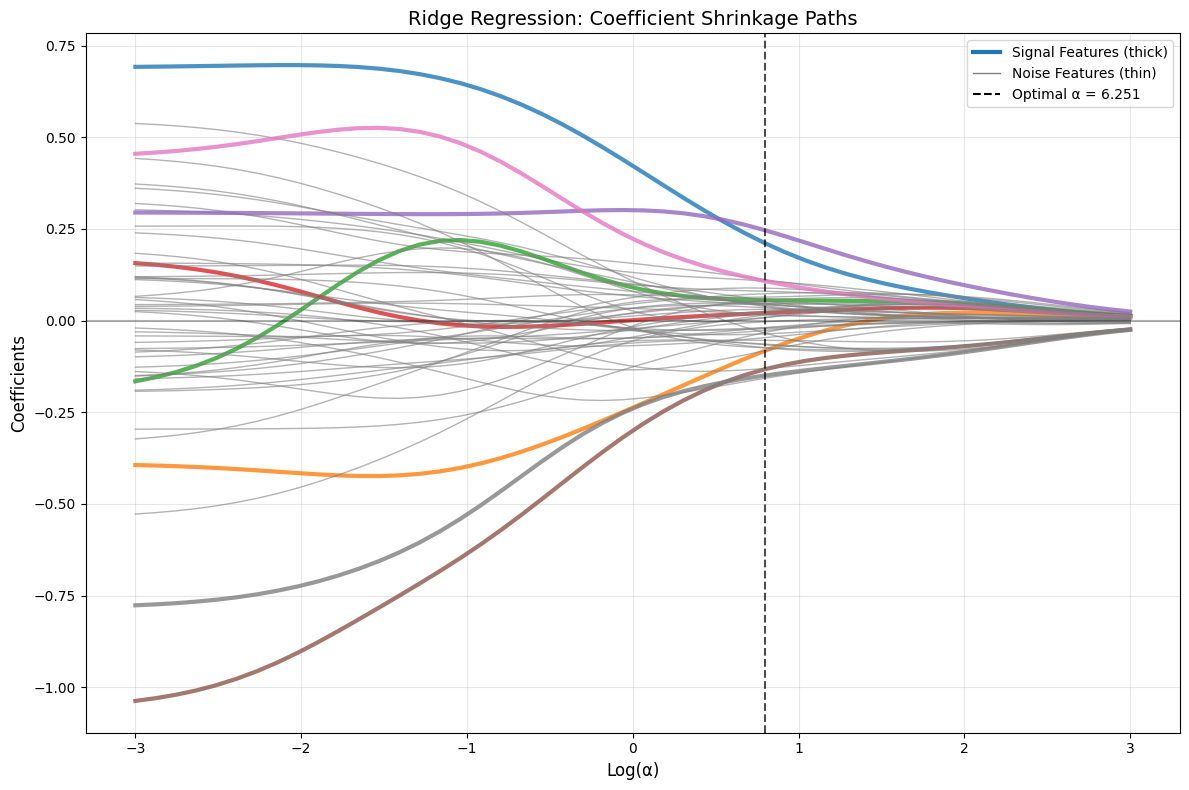

In [116]:
# Plot coefficient paths for Ridge regression
plt.figure(figsize=(12, 8))

# Store coefficients for each alpha
coefficients = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefficients.append(ridge.coef_)

coefficients = np.array(coefficients)

# Plot coefficient paths
signal_features = [0, 2, 5, 8, 12, 15, 20, 25]

for feature_idx in range(n_features):
    if feature_idx in signal_features:
        # Thick lines for signal features
        plt.plot(np.log10(alphas), coefficients[:, feature_idx], 
                linewidth=3, alpha=0.8, 
                label=f'Signal Feature {feature_idx}' if feature_idx in signal_features[:4] else "")
    else:
        # Thin lines for noise features
        plt.plot(np.log10(alphas), coefficients[:, feature_idx], 
                linewidth=1, alpha=0.6, color='gray')

# Add vertical line at optimal alpha
plt.axvline(x=np.log10(optimal_alpha), color='black', linestyle='--', alpha=0.7,
           label=f'Optimal α = {optimal_alpha:.3f}')

# Add horizontal line at zero
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.xlabel('Log(α)', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.title('Ridge Regression: Coefficient Shrinkage Paths', fontsize=14)
plt.grid(True, alpha=0.3)

# Create custom legend
import matplotlib.lines as mlines
signal_line = mlines.Line2D([], [], color='C0', linewidth=3, label='Signal Features (thick)')
noise_line = mlines.Line2D([], [], color='gray', linewidth=1, label='Noise Features (thin)')
optimal_line = mlines.Line2D([], [], color='black', linestyle='--', label=f'Optimal α = {optimal_alpha:.3f}')
plt.legend(handles=[signal_line, noise_line, optimal_line], loc='upper right')

plt.tight_layout()
plt.show()

**Key Observations:**
- **Signal features (thick lines) and Noise features (thin gray lines)**: Start with meaningful coefficients, shrink gradually toward zero
- **At optimal α**: Signal features retain reasonable values while noise is heavily suppressed
- **Important limitation**: No coefficients become exactly zero - Ridge keeps all features

Ridge regression effectively reduces coefficient magnitudes but doesn't eliminate irrelevant features entirely. What if we want **automatic feature selection** - a method that can set coefficients to exactly zero and tell us which features to ignore completely?

Let's explore **Lasso regression**, a tool designed specifically for this purpose.

<br><br>
## LASSO Regression: Zeroing Out Irrelevant Features

**The Core Idea:**
LASSO (Least Absolute Shrinkage and Selection Operator) adds a different penalty term that can actually **eliminate features** by setting coefficients to exactly zero:

**LASSO Regression:**
Loss = MSE + α × Σ|β|

**Key Differences from Ridge:**
- **L1 Penalty**: Penalizes the **sum of absolute coefficients β** (not squared)
- **Sparse Solutions**: Prefers to set coefficients to **exactly zero**
- **Automatic Feature Selection**: Eliminates irrelevant features completely
- **Sharp Corners**: L1 penalty creates "corners" at zero that trap coefficients

**When LASSO Shines:**
- Only a few features are truly relevant (sparse signals)
- Want automatic feature selection and interpretability
- Prefer simple models with fewer active features
- Need to identify the most important predictors

Again let's investigate the CV score depending on the chosen α.

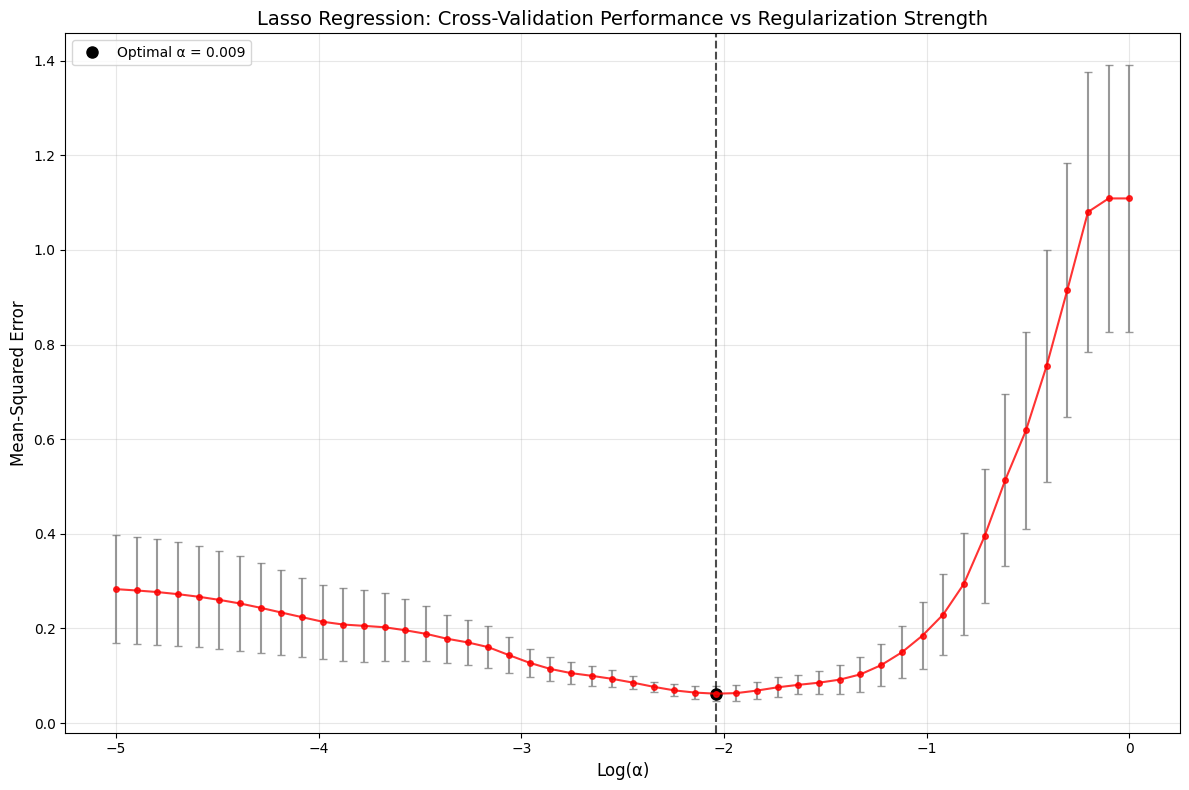

In [128]:
# Define range of alpha values (regularization strength)
# Use log scale from very small to very large values
alphas = np.logspace(-5, 0, 50)  # From 0.001 to 1,000

# Store cross-validation scores
cv_scores = []
cv_stds = []

# Cross-validation for each alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    scores = cross_val_score(lasso, X_train, y_train, 
                           cv=5, scoring='neg_mean_squared_error')
    
    # Convert to positive MSE
    cv_scores.append(-scores.mean())
    cv_stds.append(scores.std())

# Convert to numpy arrays for easier manipulation
cv_scores = np.array(cv_scores)
cv_stds = np.array(cv_stds)

# Plot results
plt.figure(figsize=(12, 8))
plt.errorbar(np.log10(alphas), cv_scores, yerr=cv_stds, 
             marker='o', markersize=4, capsize=3, capthick=1,
             color='red', ecolor='gray', alpha=0.8)

# Find optimal alpha
optimal_idx = np.argmin(cv_scores)
optimal_alpha = alphas[optimal_idx]
optimal_score = cv_scores[optimal_idx]

# Mark optimal point
plt.axvline(x=np.log10(optimal_alpha), color='black', linestyle='--', alpha=0.7)
plt.plot(np.log10(optimal_alpha), optimal_score, 'ko', markersize=8, 
         label=f'Optimal α = {optimal_alpha:.3f}')

# Add number of effective degrees of freedom on top
n_features_used = []
for alpha in alphas[::5]:  # Sample every 5th alpha for performance
    lasso_temp = Lasso(alpha=alpha)
    lasso_temp.fit(X_train, y_train)
    # Approximate degrees of freedom for lasso regression
    H = X_train @ np.linalg.inv(X_train.T @ X_train + alpha * np.eye(X_train.shape[1])) @ X_train.T
    df = np.trace(H)
    n_features_used.append(int(df))

plt.xlabel('Log(α)', fontsize=12)
plt.ylabel('Mean-Squared Error', fontsize=12)
plt.title('Lasso Regression: Cross-Validation Performance vs Regularization Strength', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

**Key Insights:** 
- Optimal α = 0.009 achieves excellent performance similar to Ridge
- **Sharp performance cliff**: Very high regularization quickly degrades performance

Let's examine the coefficient paths to see if Lasso actually sets coefficients to exactly zero, enabling true feature selection.

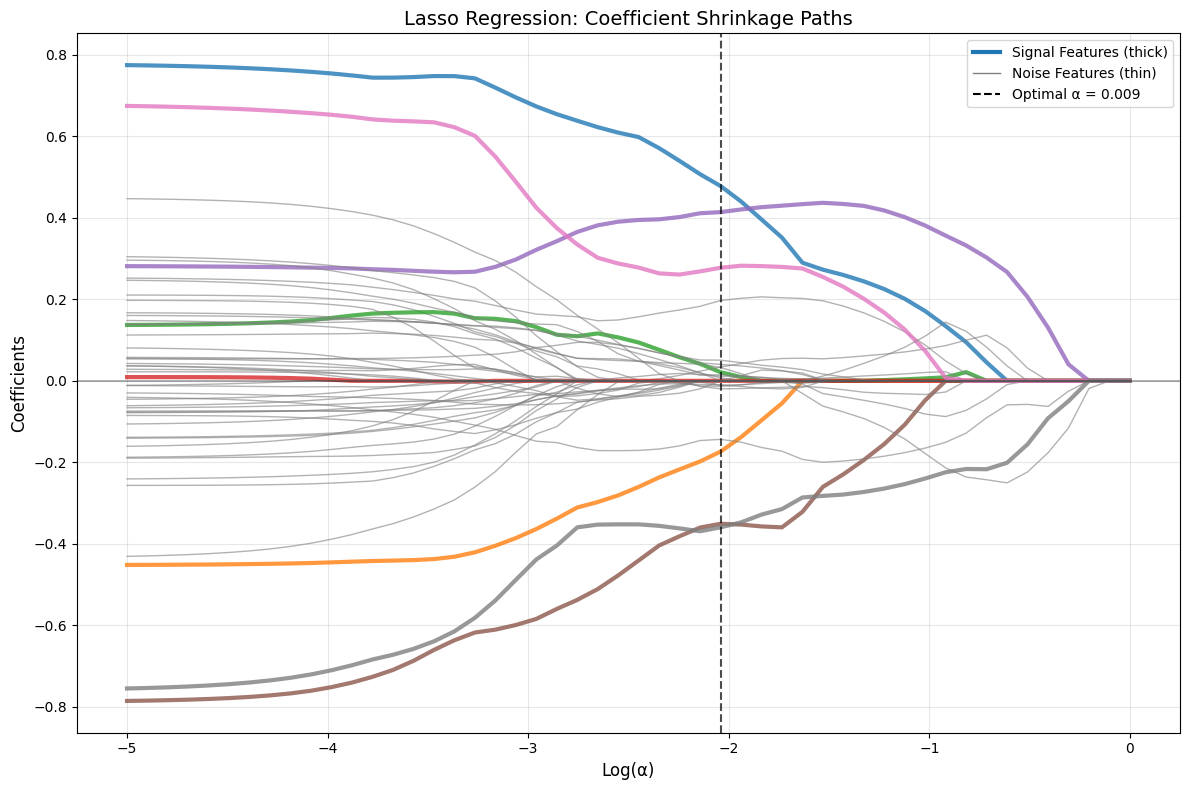

In [129]:
# Plot coefficient paths for Lasso regression
plt.figure(figsize=(12, 8))

# Store coefficients for each alpha
coefficients = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    coefficients.append(lasso.coef_)

coefficients = np.array(coefficients)

# Plot coefficient paths
signal_features = [0, 2, 5, 8, 12, 15, 20, 25]

for feature_idx in range(n_features):
    if feature_idx in signal_features:
        # Thick lines for signal features
        plt.plot(np.log10(alphas), coefficients[:, feature_idx], 
                linewidth=3, alpha=0.8, 
                label=f'Signal Feature {feature_idx}' if feature_idx in signal_features[:4] else "")
    else:
        # Thin lines for noise features
        plt.plot(np.log10(alphas), coefficients[:, feature_idx], 
                linewidth=1, alpha=0.6, color='gray')

# Add vertical line at optimal alpha
plt.axvline(x=np.log10(optimal_alpha), color='black', linestyle='--', alpha=0.7,
           label=f'Optimal α = {optimal_alpha:.3f}')

# Add horizontal line at zero
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.xlabel('Log(α)', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.title('Lasso Regression: Coefficient Shrinkage Paths', fontsize=14)
plt.grid(True, alpha=0.3)

# Create custom legend
import matplotlib.lines as mlines
signal_line = mlines.Line2D([], [], color='C0', linewidth=3, label='Signal Features (thick)')
noise_line = mlines.Line2D([], [], color='gray', linewidth=1, label='Noise Features (thin)')
optimal_line = mlines.Line2D([], [], color='black', linestyle='--', label=f'Optimal α = {optimal_alpha:.3f}')
plt.legend(handles=[signal_line, noise_line, optimal_line], loc='upper right')

plt.tight_layout()
plt.show()

**Dramatic Difference from Ridge:**
- **Complete elimination**: Many coefficients hit exactly zero (horizontal line)
- **Sequential removal**: Features are eliminated as α increases
- **Smart selection**: At optimal α, most signal features (thick lines) survive while noise features (thin gray) are eliminated

Lasso successfully identified and retained the important predictive features while discarding the irrelevant ones. Let's examine exactly which features were selected at the optimal regularization strength.

In [120]:
from sklearn.linear_model import Lasso

# Fit Lasso with optimal alpha to get selected features
lasso_optimal = Lasso(alpha=optimal_alpha)
lasso_optimal.fit(X_train, y_train)

# Get non-zero coefficients (selected features)
selected_features = np.where(lasso_optimal.coef_ != 0)[0]
selected_coeffs = lasso_optimal.coef_[selected_features]

print(f"Lasso Feature Selection Results (α = {optimal_alpha:.4f}):")
print(f"Total features selected: {len(selected_features)} out of {n_features}")
print("\nSelected Features:")
print("Feature Index | Coefficient | True Signal?")
print("-" * 40)

for feat_idx, coeff in zip(selected_features, selected_coeffs):
    is_signal = "✓" if feat_idx in signal_features else "✗"
    print(f"{feat_idx:12d} | {coeff:10.4f} | {is_signal}")

# Calculate accuracy of feature selection
true_positives = len(set(selected_features) & set(signal_features))
false_positives = len(set(selected_features) - set(signal_features))
false_negatives = len(set(signal_features) - set(selected_features))

precision = true_positives / len(selected_features) if len(selected_features) > 0 else 0
recall = true_positives / len(signal_features)

print(f"\nFeature Selection Performance:")
print(f"True Positives: {true_positives}/8")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")

Lasso Feature Selection Results (α = 0.0091):
Total features selected: 21 out of 50

Selected Features:
Feature Index | Coefficient | True Signal?
----------------------------------------
           0 |     0.4779 | ✓
           2 |    -0.1736 | ✓
           5 |     0.0212 | ✓
           6 |     0.0338 | ✗
           7 |     0.0114 | ✗
           9 |     0.1970 | ✗
          11 |     0.0507 | ✗
          12 |     0.4139 | ✓
          15 |    -0.3507 | ✓
          17 |    -0.0137 | ✗
          19 |    -0.0196 | ✗
          20 |     0.2774 | ✓
          24 |     0.0073 | ✗
          25 |    -0.3595 | ✓
          26 |    -0.0101 | ✗
          27 |    -0.1436 | ✗
          29 |    -0.0108 | ✗
          33 |    -0.0001 | ✗
          36 |     0.0328 | ✗
          44 |     0.0402 | ✗
          48 |     0.0148 | ✗

Feature Selection Performance:
True Positives: 7/8
False Positives: 14
False Negatives: 1


**Effective Feature Selection:**
- **Reduced dimensionality**: 21 features selected out of original 50 (58% reduction)
- **Signal recovery**: 7 out of 8 true signal features correctly identified
- **Smart coefficient sizing**: The incorrectly selected noise features have very small coefficients (most < 0.05)

While Lasso didn't achieve perfect feature selection, it successfully identified the most important predictive features and assigned them substantial coefficients, while keeping noise feature coefficients small. This creates an interpretable model that focuses on the truly important variables.

Next we look at a tool that combines these two tools.

<br><br>
## Elastic Net: Combining Ridge and LASSO

**The Core Idea:**
Elastic Net combines both L1 (LASSO) and L2 (Ridge) penalties to get the benefits of both regularization methods:

**Elastic Net Regression:**
Loss = MSE + α × [λ × Σ|β| + (1-λ) × Σ(β²)]

**Two Key Parameters:**
- **α (alpha)**: Overall regularization strength
- **λ (l1_ratio)**: Mix between L1 and L2 penalties
  - λ = 0: Pure Ridge regression
  - λ = 1: Pure LASSO regression  
  - λ = 0.5: Equal mix of both penalties

**How Elastic Net Works:**
- **Feature Selection**: L1 component can eliminate features (like LASSO)
- **Stability**: L2 component provides smooth shrinkage (like Ridge)
- **Group Selection**: Can select groups of correlated features together
- **Balance**: Automatically finds optimal mix of sparsity and stability

**When Elastic Net Excels:**
- When you want both feature selection AND stability
- With correlated feature groups (selects multiple from group vs LASSO's arbitrary choice)
- When you're unsure whether Ridge or LASSO is better
- For robust feature selection across different data samples

Let's investigate CV scores for different α, keeping λ at 0.5 (balanced penalties).

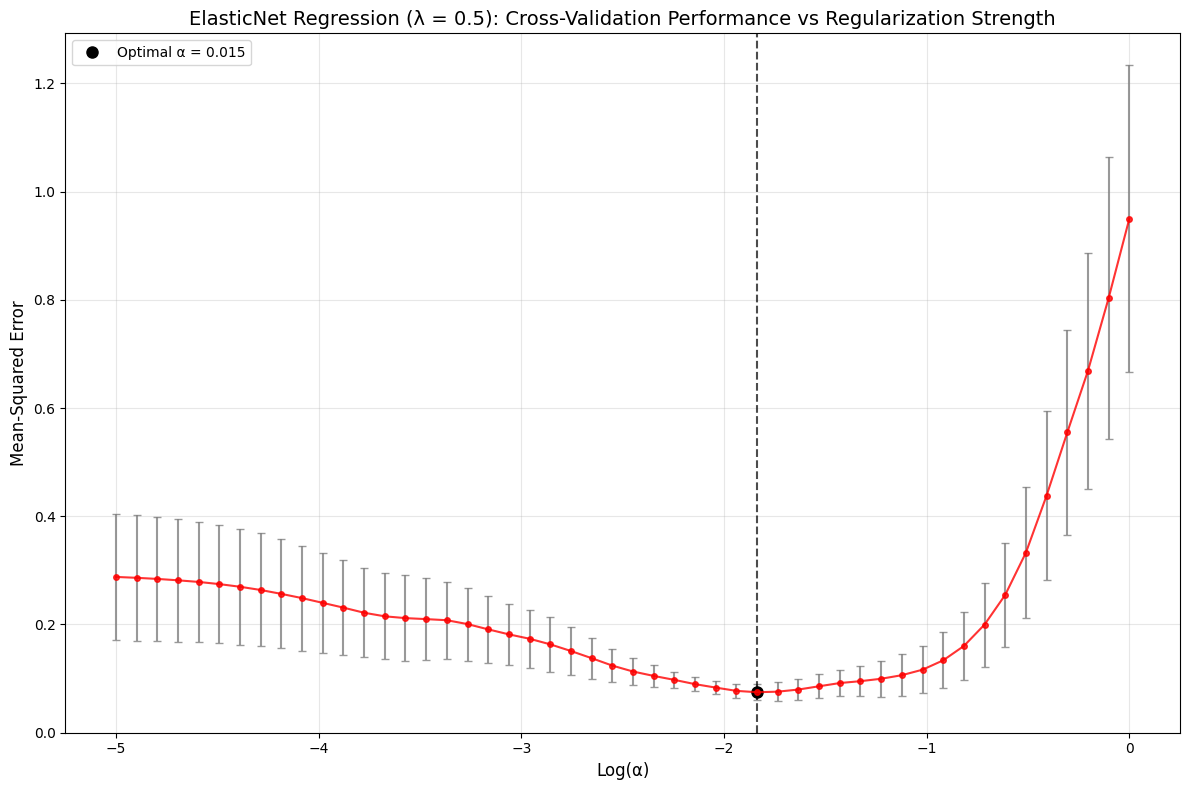

In [130]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define range of alpha values (regularization strength)
# Use log scale from very small to very large values
alphas = np.logspace(-5, 0, 50)  # From 0.001 to 1,000
lambda_ratio = 0.5  # Ratio of L1 to L2 regularization

# Store cross-validation scores
cv_scores = []
cv_stds = []

# Cross-validation for each alpha
for alpha in alphas:
    elastic = ElasticNet(alpha=alpha, l1_ratio=lambda_ratio)
    scores = cross_val_score(elastic, X_train, y_train, 
                           cv=5, scoring='neg_mean_squared_error')
    
    # Convert to positive MSE
    cv_scores.append(-scores.mean())
    cv_stds.append(scores.std())

# Convert to numpy arrays for easier manipulation
cv_scores = np.array(cv_scores)
cv_stds = np.array(cv_stds)

# Plot results
plt.figure(figsize=(12, 8))
plt.errorbar(np.log10(alphas), cv_scores, yerr=cv_stds, 
             marker='o', markersize=4, capsize=3, capthick=1,
             color='red', ecolor='gray', alpha=0.8)

# Find optimal alpha
optimal_idx = np.argmin(cv_scores)
optimal_alpha = alphas[optimal_idx]
optimal_score = cv_scores[optimal_idx]

# Mark optimal point
plt.axvline(x=np.log10(optimal_alpha), color='black', linestyle='--', alpha=0.7)
plt.plot(np.log10(optimal_alpha), optimal_score, 'ko', markersize=8, 
         label=f'Optimal α = {optimal_alpha:.3f}')

# Add number of effective degrees of freedom on top
n_features_used = []
for alpha in alphas[::5]:  # Sample every 5th alpha for performance
    elastic_temp = ElasticNet(alpha=alpha, l1_ratio=lambda_ratio)
    elastic_temp.fit(X_train, y_train)
    # Approximate degrees of freedom for elastic regression
    H = X_train @ np.linalg.inv(X_train.T @ X_train + alpha * np.eye(X_train.shape[1])) @ X_train.T
    df = np.trace(H)
    n_features_used.append(int(df))

plt.xlabel('Log(α)', fontsize=12)
plt.ylabel('Mean-Squared Error', fontsize=12)
plt.title('ElasticNet Regression (λ = 0.5): Cross-Validation Performance vs Regularization Strength', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

At α = 0.015, ElasticNet achieves excellent cross-validation performance by combining L1 (Lasso) and L2 (Ridge) penalties in equal proportions (λ = 0.5). This hybrid approach captures benefits from both regularization types.

How does performance change when we adjust the mixing ratio λ? Let's compare different values from pure Ridge (λ = 0) to pure Lasso (λ = 1).

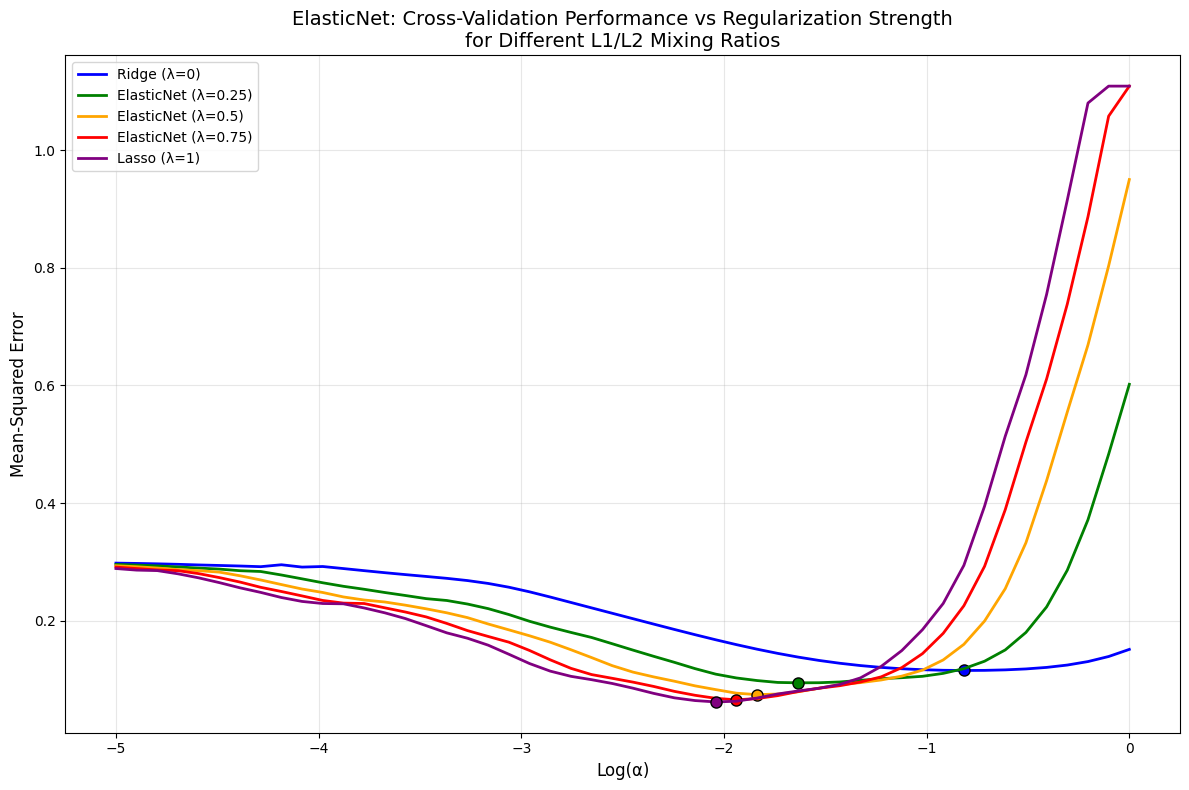

Optimal Results for Each Method:
Method | L1 Ratio | Optimal α | CV MSE
---------------------------------------------
Ridge (λ=0)          |     0.00 |    0.1526 | 0.1156
ElasticNet (λ=0.25)  |     0.25 |    0.0233 | 0.0947
ElasticNet (λ=0.5)   |     0.50 |    0.0146 | 0.0746
ElasticNet (λ=0.75)  |     0.75 |    0.0115 | 0.0657
Lasso (λ=1)          |     1.00 |    0.0091 | 0.0622

Best Overall Performance:
Method: Lasso (λ=1)
L1 Ratio: 1.0
Optimal α: 0.0091
CV MSE: 0.0622


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define range of alpha values and l1_ratio values
alphas = np.logspace(-5, 0, 50)  # From 0.00001 to 1
l1_ratios = [0, 0.25, 0.5, 0.75, 1.0]  # Different mixing ratios

# Colors for different l1_ratios
colors = ['blue', 'green', 'orange', 'red', 'purple']
labels = ['Ridge (λ=0)', 'ElasticNet (λ=0.25)', 'ElasticNet (λ=0.5)', 
          'ElasticNet (λ=0.75)', 'Lasso (λ=1)']

plt.figure(figsize=(12, 8))

# Store optimal results for each l1_ratio
optimal_results = []

for i, l1_ratio in enumerate(l1_ratios):
    cv_scores = []
    
    # Cross-validation for each alpha
    for alpha in alphas:
        elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=2000)
        scores = cross_val_score(elastic, X_train, y_train, 
                               cv=5, scoring='neg_mean_squared_error')
        cv_scores.append(-scores.mean())
    
    cv_scores = np.array(cv_scores)
    
    # Plot line for this l1_ratio
    plt.plot(np.log10(alphas), cv_scores, 
             color=colors[i], linewidth=2, label=labels[i])
    
    # Find optimal alpha for this l1_ratio
    optimal_idx = np.argmin(cv_scores)
    optimal_alpha = alphas[optimal_idx]
    optimal_score = cv_scores[optimal_idx]
    optimal_results.append((l1_ratio, optimal_alpha, optimal_score))
    
    # Mark optimal point
    plt.plot(np.log10(optimal_alpha), optimal_score, 'o', 
             color=colors[i], markersize=8, markeredgecolor='black', markeredgewidth=1)

plt.xlabel('Log(α)', fontsize=12)
plt.ylabel('Mean-Squared Error', fontsize=12)
plt.title('ElasticNet: Cross-Validation Performance vs Regularization Strength\nfor Different L1/L2 Mixing Ratios', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Print optimal results
print("Optimal Results for Each Method:")
print("Method | L1 Ratio | Optimal α | CV MSE")
print("-" * 45)
for l1_ratio, opt_alpha, opt_score in optimal_results:
    method_name = labels[l1_ratios.index(l1_ratio)]
    print(f"{method_name:20s} | {l1_ratio:8.2f} | {opt_alpha:9.4f} | {opt_score:.4f}")

# Find overall best method
best_idx = np.argmin([result[2] for result in optimal_results])
best_method = labels[best_idx]
best_l1_ratio, best_alpha, best_score = optimal_results[best_idx]

**Key Findings:**
- **Pure Lasso wins**: λ = 1 (purple line) achieves the lowest CV error for our dataset
- **Performance degradation**: As we move toward Ridge (λ → 0), optimal performance gets progressively worse
- **Feature selection advantage**: Our sparse signal structure favors Lasso's aggressive feature elimination over Ridge's gentle shrinkage
- **Similar optimal regions**: All methods converge to similar α values around 0.01

When the true underlying model is sparse (few important features), Lasso's feature selection capability outperforms Ridge's coefficient shrinkage. Note however, that this can be dataset-specific and is not a general insight!

Let's examine the coefficient paths to see how different λ values affect feature selection.

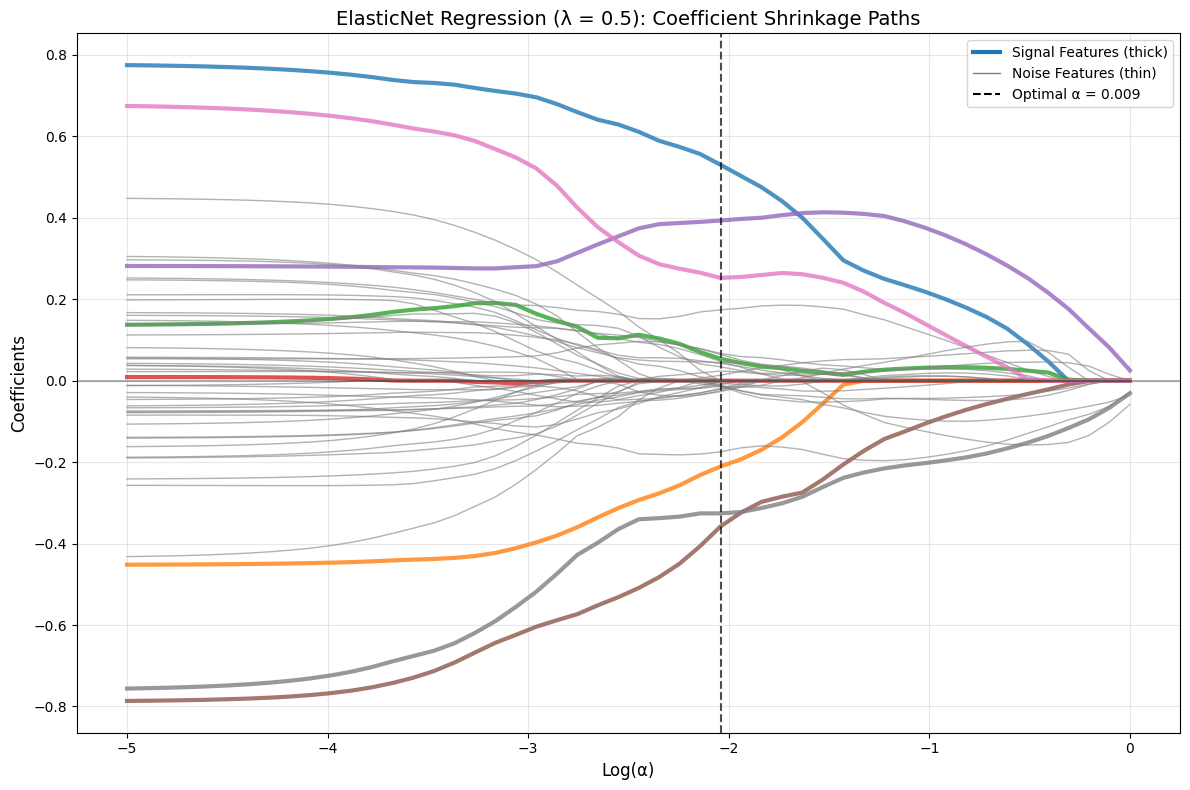

In [124]:
# Plot coefficient paths for ElasticNet regression
plt.figure(figsize=(12, 8))

# Store coefficients for each alpha
coefficients = []

for alpha in alphas:
    elastic = ElasticNet(alpha=alpha, l1_ratio=lambda_ratio)
    elastic.fit(X_train, y_train)
    coefficients.append(elastic.coef_)

coefficients = np.array(coefficients)

# Plot coefficient paths
signal_features = [0, 2, 5, 8, 12, 15, 20, 25]

for feature_idx in range(n_features):
    if feature_idx in signal_features:
        # Thick lines for signal features
        plt.plot(np.log10(alphas), coefficients[:, feature_idx], 
                linewidth=3, alpha=0.8, 
                label=f'Signal Feature {feature_idx}' if feature_idx in signal_features[:4] else "")
    else:
        # Thin lines for noise features
        plt.plot(np.log10(alphas), coefficients[:, feature_idx], 
                linewidth=1, alpha=0.6, color='gray')

# Add vertical line at optimal alpha
plt.axvline(x=np.log10(optimal_alpha), color='black', linestyle='--', alpha=0.7,
           label=f'Optimal α = {optimal_alpha:.3f}')

# Add horizontal line at zero
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.xlabel('Log(α)', fontsize=12)
plt.ylabel('Coefficients', fontsize=12)
plt.title('ElasticNet Regression (λ = 0.5): Coefficient Shrinkage Paths', fontsize=14)
plt.grid(True, alpha=0.3)

# Create custom legend
import matplotlib.lines as mlines
signal_line = mlines.Line2D([], [], color='C0', linewidth=3, label='Signal Features (thick)')
noise_line = mlines.Line2D([], [], color='gray', linewidth=1, label='Noise Features (thin)')
optimal_line = mlines.Line2D([], [], color='black', linestyle='--', label=f'Optimal α = {optimal_alpha:.3f}')
plt.legend(handles=[signal_line, noise_line, optimal_line], loc='upper right')

plt.tight_layout()
plt.show()

**Hybrid Behavior:**
- **Later elimination**: Features reach zero later than pure Lasso, showing the influence of Ridge's L2 penalty
- **Smoother transitions**: Coefficients shrink more gradually before hitting zero (less abrupt than Lasso)
- **Balanced approach**: At optimal α, ElasticNet still achieves feature selection while maintaining some Ridge-like stability

ElasticNet (λ = 0.5) provides a middle ground - more conservative feature elimination than Lasso but still achieves sparsity, making it useful when you want some feature selection with less aggressive pruning.

## Regularization Methods Overview

Here's a comprehensive summary of the regularization techniques we've explored, helping you choose the right method for your specific problem:

| Method | Penalty | Feature Selection | Correlated Features | Interpretability | Best Use Case |
|--------|---------|-------------------|-------------------|------------------|---------------|
| **Ridge** | L2 (Σβ²) | No - shrinks only | Handles well | Limited | Many correlated predictors |
| **LASSO** | L1 (Σ\|β\|) | Yes - automatic | Arbitrary selection | High | Sparse, interpretable models |
| **Elastic Net** | L1 + L2 | Yes - controlled | Group selection | Good | Balance of sparsity & stability |

---
<br><br>
# Transfer to real-world dataset: Diabetes Disease Progression

Now let's apply our PC and regularization regression knowledge to a real medical dataset. We'll work with the **diabetes dataset**, which contains:

**Dataset Overview:**
- **442 patients** with diabetes
- **Target variable**: Quantitative measure of disease progression one year after baseline
- **64 features** total:
  - 10 baseline variables (age, sex, BMI, blood pressure, 6 blood serum measurements)
  - Quadratic terms for enhanced modeling flexibility
- **Moderate dimensionality**: 64 features for 442 samples

**Clinical Goals:**
1. **Prediction**: Accurately forecast disease progression for future patients
2. **Feature importance**: Identify which biological factors most influence disease progression
3. **Model interpretability**: Create a clinically meaningful model that doctors can understand and trust

This dataset is ideal for comparing **PCA regression** (dimensionality reduction) with **regularization methods** (Ridge, Lasso, ElasticNet) in a real healthcare context where both prediction accuracy and interpretability matter.

In [138]:
# Load dataset, then perform pc regression then perform all regularization methods (plot with cv scores in upper row and coefficients in lower row), then coefficent plot
import pyreadr

# Read the RDS file
result = pyreadr.read_r('diabetes.rds')

diabetes_data = result[None]  # or result[list(result.keys())[0]]

# If it's a data frame, you'll get a pandas DataFrame
print(diabetes_data.head())

              y       age       sex       bmi       map        tc       ldl  \
rownames                                                                      
1         151.0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821   
2          75.0 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163   
3         141.0  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194   
4         206.0 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991   
5         135.0  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596   

               hdl       tch       ltg  ...   ldl.hdl   ldl.tch   ldl.ltg  \
rownames                                ...                                 
1        -0.043401 -0.002592  0.019908  ...  0.042355 -0.022038 -0.031125   
2         0.074412 -0.039493 -0.068330  ... -0.021256 -0.011564  0.012973   
3        -0.032356 -0.002592  0.002864  ...  0.033587 -0.022063 -0.018016   
4        -0.036038  0.034309  0.022692  ... -0.009878 -0.0099

We'll first examine how many principal components are needed to capture the data's variance and achieve optimal prediction performance. The following plots show the cumulative variance explained and cross-validation scores for different numbers of principal components.

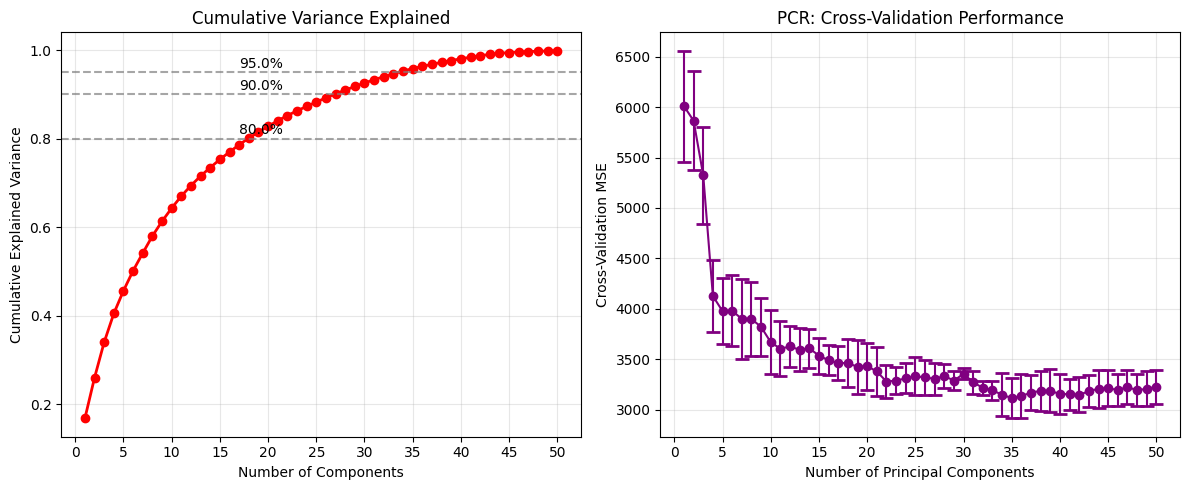

Optimal number of components: 35
Best CV MSE: 3114.41
Variance explained with 35 components: 0.958
Components needed for 80.0% variance: 18
Components needed for 90.0% variance: 27
Components needed for 95.0% variance: 34
Components needed for 99.0% variance: 43


In [ ]:
# Load data and separate features/target
X = diabetes_data.drop('y', axis=1)
y = diabetes_data['y']

# Step 1: Standardize the features (essential for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Fit PCA on all components first to analyze variance
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for different variance thresholds
thresholds = [0.8, 0.9, 0.95, 0.99]
components_needed = {}
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    components_needed[threshold] = n_components

# Cross-validation for PCR with different numbers of components
n_components_range = range(1, 51)  # Test 1 to 20 components
cv_scores_pcr = []
cv_stds_pcr = []

for n_comp in n_components_range:
    # Create pipeline: PCA + Linear Regression
    pcr_pipeline = Pipeline([
        ('pca', PCA(n_components=n_comp)),
        ('regression', LinearRegression())
    ])
    
    # 5-fold cross-validation
    scores = cross_val_score(pcr_pipeline, X_scaled, y, 
                           cv=5, scoring='neg_mean_squared_error')
    
    # Convert to positive MSE and store
    cv_scores_pcr.append(-scores.mean())
    cv_stds_pcr.append(scores.std())

# Visualize results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 51), cumulative_variance[:50], 'o-', linewidth=2, color='red')
for threshold in [0.8, 0.9, 0.95]:
    plt.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7)
    plt.text(17, threshold+0.01, f'{threshold*100}%', fontsize=10)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.xticks(range(0, 51, 5))  # Set x-ticks at 0, 5, 10, 15, 20
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.errorbar(n_components_range, cv_scores_pcr, yerr=cv_stds_pcr, 
             marker='o', capsize=5, capthick=2, color='purple')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cross-Validation MSE')
plt.title('PCR: Cross-Validation Performance')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 51, 5))  # Set x-ticks at 0, 5, 10, 15, 20

plt.tight_layout()
plt.show()

# Find optimal number of components
optimal_n_comp = n_components_range[np.argmin(cv_scores_pcr)]
min_mse = min(cv_scores_pcr)
variance_at_optimal = cumulative_variance[optimal_n_comp-1]

**Key Observations:**
- **Rapid variance capture**: The first 20 components explain over 95% of the total variance
- **Early performance plateau**: Cross-validation error stabilizes around 7-10 components
- **Diminishing returns**: Additional components beyond ~10 mainly capture noise rather than predictive signal

Next, we'll examine how the three regularization methods—Ridge, Lasso, and ElasticNet (λ = 0.5)—perform on this dataset.

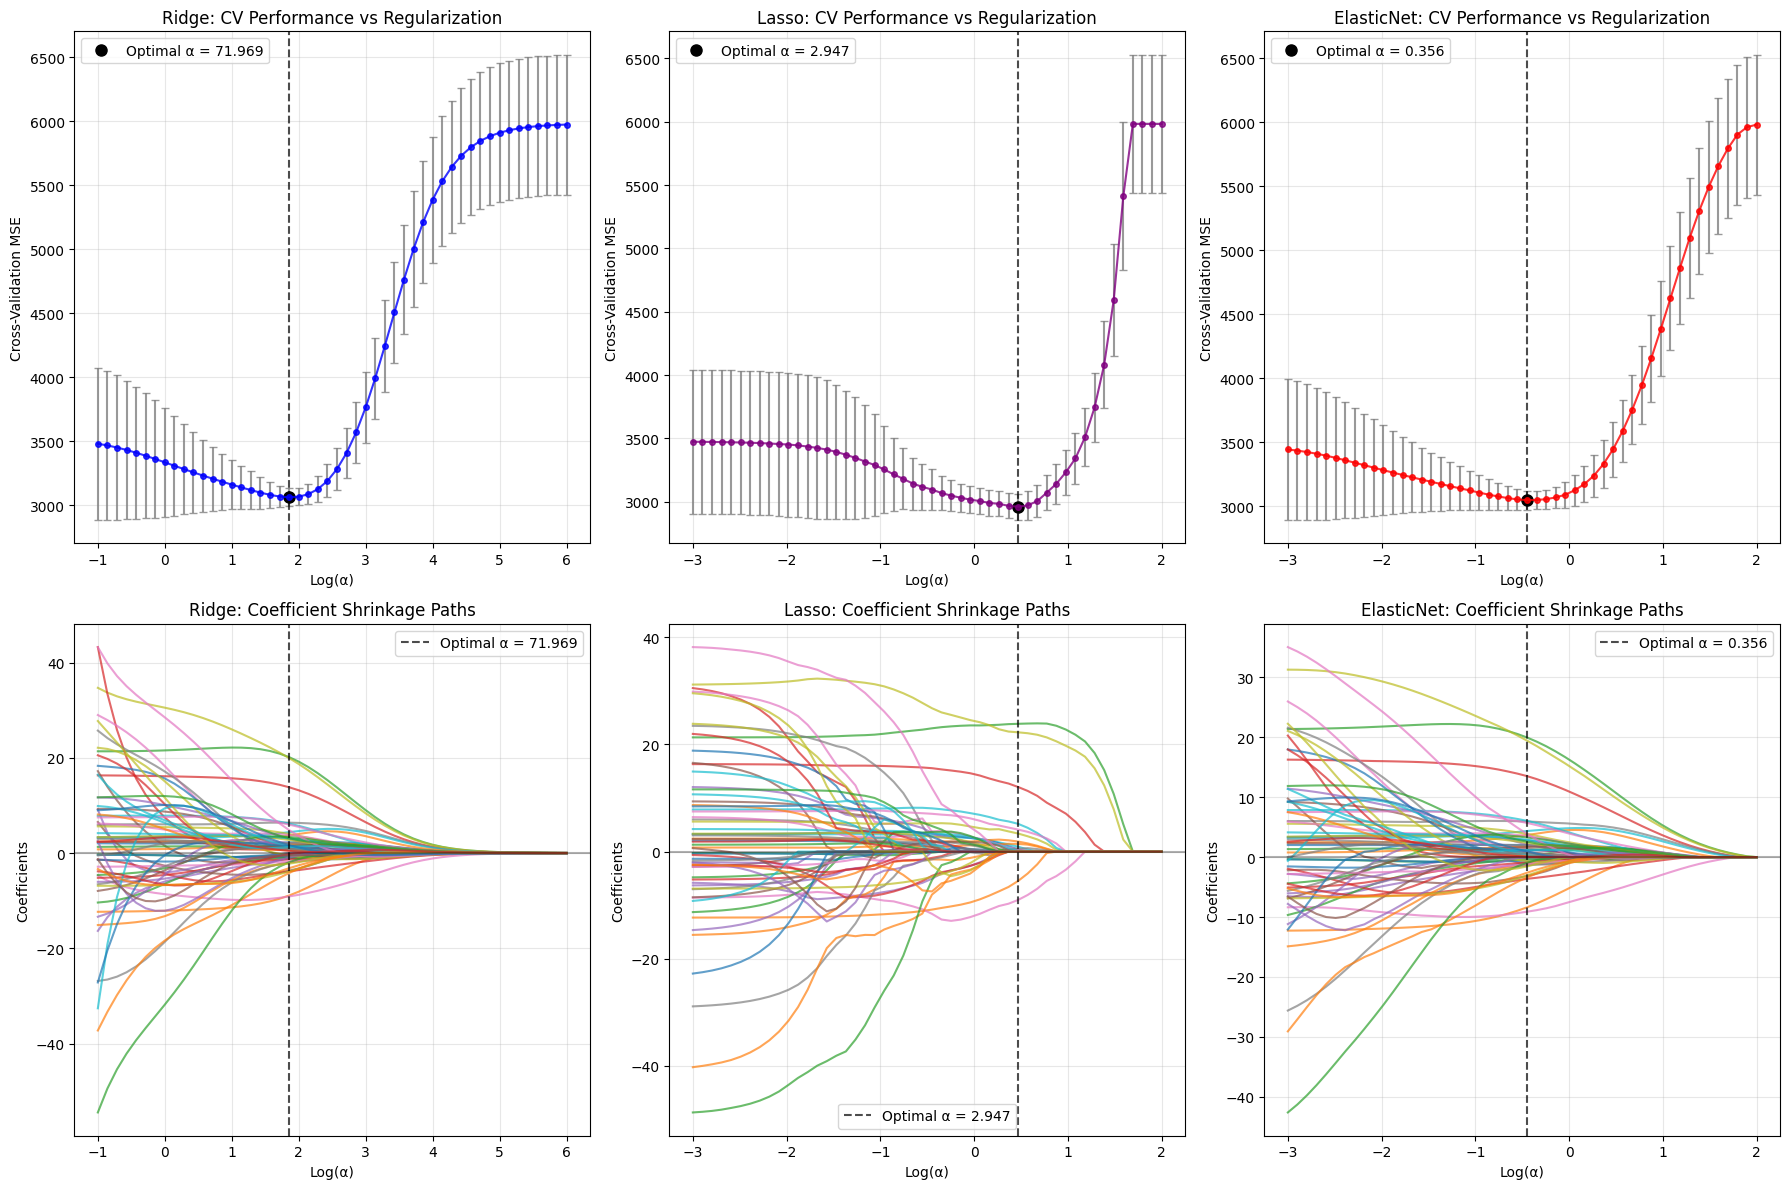

Regularization Methods Comparison:
Ridge:
  Optimal α: 71.9686
  Best CV MSE: 3062.92
  Features selected: 64/64

Lasso:
  Optimal α: 2.9471
  Best CV MSE: 2960.72
  Features selected: 15/64

ElasticNet:
  Optimal α: 0.3556
  Best CV MSE: 3046.99
  Features selected: 56/64



In [150]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define range of alpha values for each method
alphas_ridge = np.logspace(-1, 6, 50)    # Ridge: 0.001 to 100
alphas_lasso = np.logspace(-3, 2, 50)    # Lasso: 0.0001 to 10  
alphas_elastic = np.logspace(-3, 2, 50)  # ElasticNet: 0.0001 to 10

# Store results for reuse
results = {}

# Function to perform cross-validation and get coefficients
def analyze_regularization(model_class, alphas, model_name, **kwargs):
    cv_scores = []
    cv_stds = []
    coefficients = []
    
    for alpha in alphas:
        # Cross-validation
        model = model_class(alpha=alpha, **kwargs)
        scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
        cv_scores.append(-scores.mean())
        cv_stds.append(scores.std())
        
        # Fit for coefficients
        model.fit(X_scaled, y)
        coefficients.append(model.coef_)
    
    # Find optimal alpha
    optimal_idx = np.argmin(cv_scores)
    optimal_alpha = alphas[optimal_idx]
    
    return {
        'alphas': alphas,
        'cv_scores': np.array(cv_scores),
        'cv_stds': np.array(cv_stds),
        'coefficients': np.array(coefficients),
        'optimal_alpha': optimal_alpha,
        'optimal_score': cv_scores[optimal_idx]
    }

# Analyze all methods
results['Ridge'] = analyze_regularization(Ridge, alphas_ridge, 'Ridge')
results['Lasso'] = analyze_regularization(Lasso, alphas_lasso, 'Lasso')
results['ElasticNet'] = analyze_regularization(ElasticNet, alphas_elastic, 'ElasticNet', l1_ratio=0.5)

# Create the comparison plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

methods = ['Ridge', 'Lasso', 'ElasticNet']
colors = ['blue', 'purple', 'red']

# Top row: CV scores
for i, (method, color) in enumerate(zip(methods, colors)):
    ax = axes[0, i]
    result = results[method]
    
    ax.errorbar(np.log10(result['alphas']), result['cv_scores'], 
                yerr=result['cv_stds'], marker='o', markersize=4, 
                capsize=3, capthick=1, color=color, ecolor='gray', alpha=0.8)
    
    # Mark optimal point
    ax.axvline(x=np.log10(result['optimal_alpha']), color='black', 
               linestyle='--', alpha=0.7)
    ax.plot(np.log10(result['optimal_alpha']), result['optimal_score'], 
            'ko', markersize=8, label=f'Optimal α = {result["optimal_alpha"]:.3f}')
    
    ax.set_xlabel('Log(α)')
    ax.set_ylabel('Cross-Validation MSE')
    ax.set_title(f'{method}: CV Performance vs Regularization')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Bottom row: Coefficient paths
for i, (method, color) in enumerate(zip(methods, colors)):
    ax = axes[1, i]
    result = results[method]
    
    # Plot all coefficient paths
    for feature_idx in range(X_scaled.shape[1]):
        ax.plot(np.log10(result['alphas']), result['coefficients'][:, feature_idx], 
                linewidth=1.5, alpha=0.7)
    
    # Mark optimal alpha
    ax.axvline(x=np.log10(result['optimal_alpha']), color='black', 
               linestyle='--', alpha=0.7, label=f'Optimal α = {result["optimal_alpha"]:.3f}')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    ax.set_xlabel('Log(α)')
    ax.set_ylabel('Coefficients')
    ax.set_title(f'{method}: Coefficient Shrinkage Paths')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Print summary
print("Regularization Methods Comparison:")
print("="*50)
for method in methods:
    result = results[method]
    print(f"{method}:")
    print(f"  Optimal α: {result['optimal_alpha']:.4f}")
    print(f"  Best CV MSE: {result['optimal_score']:.2f}")
    
    # Count non-zero coefficients at optimal alpha
    optimal_idx = np.argmin(result['cv_scores'])
    non_zero_coefs = np.sum(np.abs(result['coefficients'][optimal_idx]) > 1e-6)
    print(f"  Features selected: {non_zero_coefs}/{X_scaled.shape[1]}")
    print()

**Regularization Methods Performance:**
- **Similar optimal performance**: All three methods achieve comparable cross-validation MSE (~3000-3500)
- **Different regularization strengths**: Optimal α values vary significantly across methods (Ridge: 71.969, Lasso: 2.947, ElasticNet: 0.356)

All methods perform reasonably well on this dataset. Let's investigate how the coefficients differ across all four approaches (including PCR)!

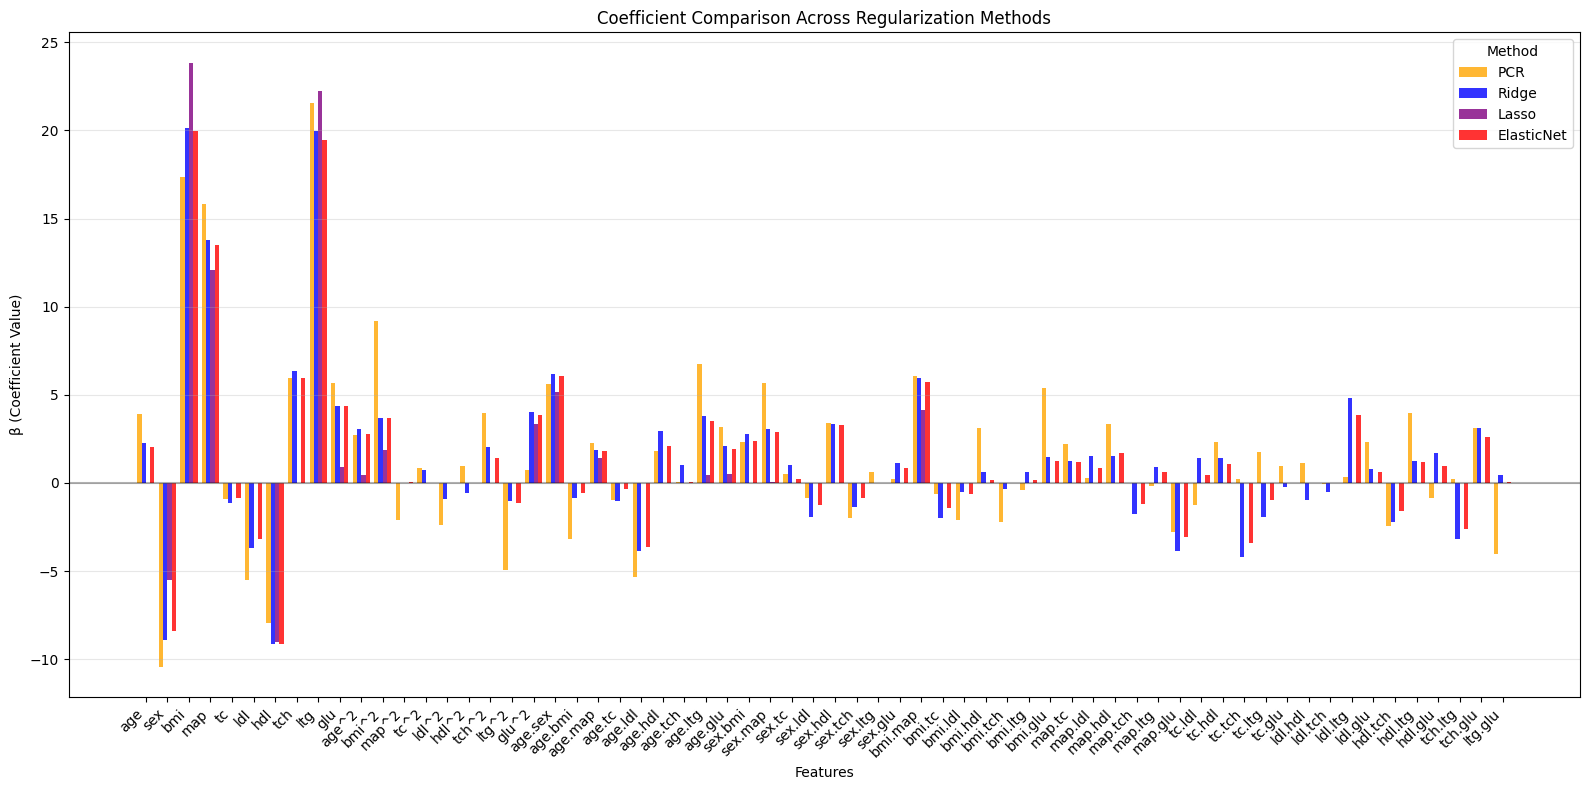

Coefficient Summary:
PCR:
  Non-zero coefficients: 64/64
  Max |coefficient|: 21.559
  Mean |coefficient|: 3.458

Ridge:
  Non-zero coefficients: 64/64
  Max |coefficient|: 20.139
  Mean |coefficient|: 3.042

Lasso:
  Non-zero coefficients: 15/64
  Max |coefficient|: 23.853
  Mean |coefficient|: 1.423

ElasticNet:
  Non-zero coefficients: 56/64
  Max |coefficient|: 19.963
  Mean |coefficient|: 2.638

Top 5 Features by |Coefficient| for Each Method:
PCR:
  ltg: 21.559
  bmi: 17.362
  map: 15.856
  sex: -10.442
  bmi^2: 9.185

Ridge:
  bmi: 20.139
  ltg: 19.944
  map: 13.814
  hdl: -9.115
  sex: -8.913

Lasso:
  bmi: 23.853
  ltg: 22.266
  map: 12.062
  hdl: -9.030
  sex: -5.490

ElasticNet:
  bmi: 19.963
  ltg: 19.442
  map: 13.521
  hdl: -9.115
  sex: -8.389



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get optimal coefficients for each method
methods_coef = {}

# PCR coefficients (at optimal number of components)
pcr_pipeline = Pipeline([
    ('pca', PCA(n_components=optimal_n_comp)),
    ('regression', LinearRegression())
])
pcr_pipeline.fit(X_scaled, y)
# Transform PCA coefficients back to original feature space
pca_components = pcr_pipeline.named_steps['pca'].components_
pcr_coef_original = pcr_pipeline.named_steps['regression'].coef_ @ pca_components
methods_coef['PCR'] = pcr_coef_original

# Ridge coefficients (at optimal alpha)
ridge_optimal = Ridge(alpha=results['Ridge']['optimal_alpha'])
ridge_optimal.fit(X_scaled, y)
methods_coef['Ridge'] = ridge_optimal.coef_

# Lasso coefficients (at optimal alpha)
lasso_optimal = Lasso(alpha=results['Lasso']['optimal_alpha'])
lasso_optimal.fit(X_scaled, y)
methods_coef['Lasso'] = lasso_optimal.coef_

# ElasticNet coefficients (at optimal alpha)
elastic_optimal = ElasticNet(alpha=results['ElasticNet']['optimal_alpha'], l1_ratio=0.5)
elastic_optimal.fit(X_scaled, y)
methods_coef['ElasticNet'] = elastic_optimal.coef_

# Create DataFrame for plotting
coef_data = []
feature_names = X.columns

for method, coefficients in methods_coef.items():
    for i, (feature, coef) in enumerate(zip(feature_names, coefficients)):
        coef_data.append({
            'feature': feature,
            'beta': coef,
            'method': method,
            'feature_idx': i
        })

coef_df = pd.DataFrame(coef_data)

# Create the plot
plt.figure(figsize=(16, 8))

# Define colors for methods
method_colors = {'PCR': 'orange', 'Ridge': 'blue', 'Lasso': 'purple', 'ElasticNet': 'red'}

# Create grouped bar plot
x_pos = np.arange(len(feature_names))
width = 0.2

for i, method in enumerate(['PCR', 'Ridge', 'Lasso', 'ElasticNet']):
    method_coefs = coef_df[coef_df['method'] == method]['beta'].values
    plt.bar(x_pos + i*width, method_coefs, width, 
            label=method, color=method_colors[method], alpha=0.8)

# Customize plot
plt.xlabel('Features')
plt.ylabel('β (Coefficient Value)')
plt.title('Coefficient Comparison Across Regularization Methods')
plt.xticks(x_pos + width*1.5, feature_names, rotation=45, ha='right')
plt.legend(title='Method')
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
#print("Coefficient Summary:")
#print("="*60)
#for method in ['PCR', 'Ridge', 'Lasso', 'ElasticNet']:
#    method_coefs = methods_coef[method]
#    non_zero = np.sum(np.abs(method_coefs) > 1e-6)
#    max_coef = np.max(np.abs(method_coefs))
    
#    print(f"{method}:")
#    print(f"  Non-zero coefficients: {non_zero}/{len(method_coefs)}")
#    print(f"  Max |coefficient|: {max_coef:.3f}")
#    print(f"  Mean |coefficient|: {np.mean(np.abs(method_coefs)):.3f}")
#    print()

# Show top 5 most important features for each method
#print("Top 5 Features by |Coefficient| for Each Method:")
#print("="*60)
#for method in ['PCR', 'Ridge', 'Lasso', 'ElasticNet']:
#    method_coefs = methods_coef[method]
#    top_indices = np.argsort(np.abs(method_coefs))[-5:][::-1]
#    
#    print(f"{method}:")
#    for idx in top_indices:
#        print(f"  {feature_names[idx]}: {method_coefs[idx]:.3f}")
#    print()

- **Sparse vs. dense solutions**: Lasso eliminates many features entirely, while Ridge and PCR retain all with varying magnitudes
- **Feature agreement**: Key features like 'bmi' and 'bp' show consistent importance across methods, suggesting strong predictive signal
- **Method-specific selections**: Some features are only selected by certain methods, reflecting different regularization philosophies

**PCR Coefficient Transformation**: PCR works in the principal component space, not the original feature space. The regression coefficients are for the principal components, not the original features. To account for this we transformed the PC coefficients back to the original feature space:
```python
# PCR gives us: y = β₁·PC₁ + β₂·PC₂ + ... + βₖ·PCₖ
# But PC₁ = w₁₁·x₁ + w₁₂·x₂ + ... (linear combination of original features)
# So we compute: β_original = β_PC × W_components
pcr_coef_original = pcr_pipeline.named_steps['regression'].coef_ @ pca_components
```

The results demonstrate how different approaches handle the bias-variance tradeoff: PCR through dimensionality reduction, Ridge through uniform shrinkage, Lasso through feature selection, and ElasticNet through a balanced combination.

---